# Associations between molecular and environmental changes along the proximal-to-distal axis of the colon
### Abstract
Colorectal cancer is a heterogeneous disease and tumours in the left or right sections of the colon are molecularly and biologically disparate. The development of the two-colon paradigm, which differentiates colorectal cancers according to their location relative to the splenic flexure, contributed to an improvement in prognosis and treatment. However, recent studies challenged this division by proposing a continuum model by which molecular properties follow a continuous trend along the colon. To date, there is no clear answer on whether a continuous model would describe CRC properties along the colon better than the two-colon paradigm. In this study, we answer this question by systematically comparing the performance between continuous and left-right colon models in describing the molecular properties of colorectal tumours. We provide evidence that no model clearly outperforms the other but alterations affecting genes associated with differentiation and growth are better described by the two-colon paradigm while the continuum colon model better approximates alterations affecting genes related to metabolic and environmental factors. To understand better the environmental impact in changes on selective constraints along the colon, we chart the localised metabolome in a cohort of 27 colon cancer patients with lesions covering almost all major segments of the colon. We find that all metabolites, which can be approximated with one of the two models, follow a continuous trend, while none show a two-colon behaviour. We show that genes with continuous transcriptional profiles along the colon closely interact with metabolites associated with colon carcinogenesis, suggesting that gradients of metabolism-mediated selective constraints along the proximal-distal axis along the colon might contribute to gradual changes in tumours along the colon. Our results show that an increase in the resolution of tumour localisation in the colon might hold a robust diagnostic and prognostic potential and, hence, that treatment might benefit from taking into account the position of the tumour more precisely than left vs right.
### About this notebook
This notebook allow to reproduce all the results and figures presented in [CITAZIONE] 

# TRANSCRIPTOME PROFILING

In [1]:
import sys
sys.path.append("../../../git/lib") # Path to the profile_analysis_class.py file
from profile_analysis_class import ProfileAnalysis # Import the profile workflow class
import pandas as pd
import matplotlib.pyplot as plt
from supervenn import supervenn
import mygene

mg = mygene.MyGeneInfo()
plt.style.use('../../assets/styles/plotting_style.mplstyle') # Path to the matplotlib style sheet
# Create workflow class, specifying the path to the SETTINGS.ini file
pa_transcriptome = ProfileAnalysis('../../../docker/analysis/transcriptome')

/home/ieo5417/.local/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Project has been created!


/home/ieo5417/Documenti/colon_paper/git/notebooks/paper_analysis/../../../git/lib/profile_analysis_class.py:153: UserWarning: Folder input_data already exist...skipping
  warnings.warn("Folder input_data already exist...skipping",
/home/ieo5417/Documenti/colon_paper/git/notebooks/paper_analysis/../../../git/lib/profile_analysis_class.py:159: UserWarning: Folder data_raw already exist...skipping
  warnings.warn("Folder data_raw already exist...skipping",
/home/ieo5417/Documenti/colon_paper/git/notebooks/paper_analysis/../../../git/lib/profile_analysis_class.py:165: UserWarning: Folder data_clinical already exist...skipping
  warnings.warn("Folder data_clinical already exist...skipping",
/home/ieo5417/Documenti/colon_paper/git/notebooks/paper_analysis/../../../git/lib/profile_analysis_class.py:171: UserWarning: Folder sample_by_section already exist...skipping
  warnings.warn("Folder sample_by_section already exist...skipping",
/home/ieo5417/Documenti/colon_paper/git/notebooks/paper_anal

## Assign each sample in clinical data file to a colon section

In [2]:
pa_transcriptome.create_samples_to_sections_table()

In [3]:
pa_transcriptome.data_table.head()

,TCGA-3L-AA1B-01A,TCGA-4N-A93T-01A,TCGA-4T-AA8H-01A,TCGA-5M-AAT4-01A,TCGA-5M-AAT5-01A,TCGA-5M-AAT6-01A,TCGA-5M-AATA-01A,TCGA-5M-AATE-01A,TCGA-A6-2671-01A,TCGA-A6-2671-11A,...,TCGA-QG-A5YV-01A,TCGA-QG-A5YW-01A,TCGA-QG-A5YX-01A,TCGA-QG-A5Z1-01A,TCGA-QG-A5Z2-01A,TCGA-QL-A97D-01A,TCGA-RU-A8FL-01A,TCGA-SS-A7HO-01A,TCGA-T9-A92H-01A,TCGA-WS-AB45-01A
ensmbl_id,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,111.521997,87.819242,53.472814,136.567069,80.503587,25.376071,87.758080,111.715639,68.559570,61.700267,...,122.026482,94.325635,146.209859,138.843267,44.253162,74.177221,144.275333,130.907759,113.238423,21.011305
ENSG00000000005,0.992449,2.313451,4.579855,3.491783,8.580343,0.234741,0.670812,0.167322,0.810485,0.827035,...,8.140444,3.173229,1.861843,3.014002,1.047781,7.156551,0.954313,0.088394,1.780693,0.042671
ENSG00000000419,118.855487,121.224392,58.207131,132.121686,240.463004,96.988095,156.811413,207.788662,131.795283,53.385547,...,208.791935,85.188361,123.478879,195.940514,88.795443,184.746640,146.927140,191.187774,234.357085,65.398323
ENSG00000000457,8.770987,7.398252,4.453604,7.423455,7.229283,5.833988,7.013853,7.540641,3.670965,6.183537,...,10.227889,3.771427,8.265845,6.515947,10.971684,6.959780,7.512311,8.105107,5.892040,7.116486
ENSG00000000460,5.425457,2.478204,2.971292,8.385077,8.742189,5.795347,5.746648,8.547724,6.580370,1.211377,...,11.557421,5.098586,5.867534,5.084741,5.305513,6.842320,4.575402,8.860398,5.835609,5.342146


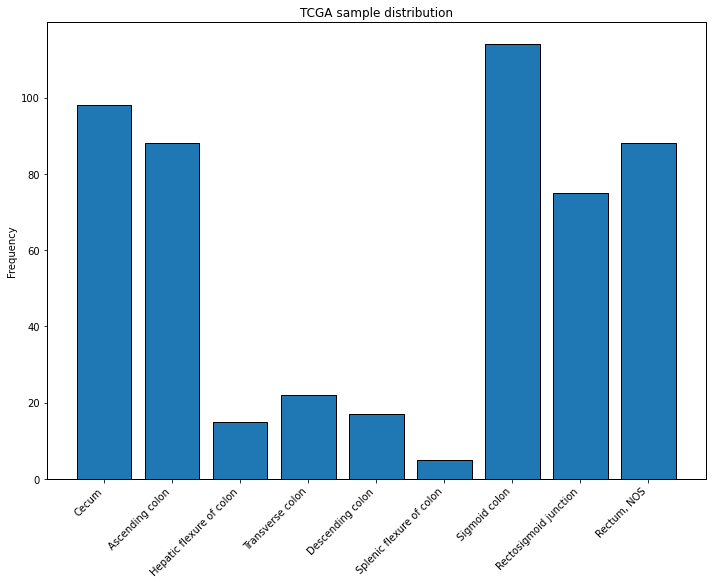

In [4]:
pa_transcriptome.plot_sample_distribution(title='TCGA sample distribution')

## Calculate median value and median average variation for each colon section

In [5]:
medians_tr, mad_tr = pa_transcriptome.median_by_section()

This step has already been executed...loading results...
This step has already been executed...loading results...


In [6]:
medians_tr.head()

,Cecum,Ascending colon,Hepatic flexure of colon,Transverse colon,Descending colon,Sigmoid colon,Rectosigmoid junction,"Rectum, NOS"
ensmbl_id,,,,,,,,
ENSG00000000003,73.907526,78.403451,103.124233,75.913878,82.543993,132.823036,133.446046,100.606220
ENSG00000000005,1.008409,0.735658,1.336772,0.798797,1.680453,1.657560,1.893015,1.379483
ENSG00000000419,99.851076,104.284560,117.657759,97.626225,154.401872,170.663164,139.689173,144.105845
ENSG00000000457,6.921388,6.640371,7.004861,7.278464,7.113812,7.131714,7.116130,6.885216
ENSG00000000460,5.263295,4.969358,5.424937,4.844178,6.057782,5.991615,5.782876,6.181672


In [7]:
mad_tr.head()

,Unnamed: 0,Cecum,Ascending colon,Hepatic flexure of colon,Transverse colon,Descending colon,Sigmoid colon,Rectosigmoid junction,"Rectum, NOS"
0,ENSG00000000003,33.045419,38.799498,58.271199,30.181981,50.004580,46.806473,40.212477,34.390195
1,ENSG00000000005,0.861570,0.636900,1.336772,0.705742,1.163834,1.457359,1.642586,0.869259
2,ENSG00000000419,32.520453,33.029376,27.774534,24.913604,76.060263,50.032742,48.295106,45.392903
3,ENSG00000000457,1.570295,1.206098,1.909975,1.633780,1.147258,1.676726,1.764332,1.417251
4,ENSG00000000460,1.378870,1.584756,1.463548,1.399207,1.997586,1.643072,1.592896,1.930137


## Fit Observables

In [8]:
scores_tr, poly_obs_scores_tr, sig_obs_scores_tr, poly_models_tr, sig_models_tr = pa_transcriptome.fit_data(medians_tr, guess_bounds = True)

This step has already been executed...loading results...
This step has already been executed...loading results...
This step has already been executed...loading results...
This step has already been executed...loading results...


## Fit Random permutated data

In [9]:
poly_perm_scores_tr, sig_perm_scores_tr, sig_perm_models_tr = pa_transcriptome.fit_random_data(medians_tr, guess_bounds = True)

This step has already been executed...loading results...
This step has already been executed...loading results...
This step has already been executed...loading results...


## Compare obrservable vs permutated data

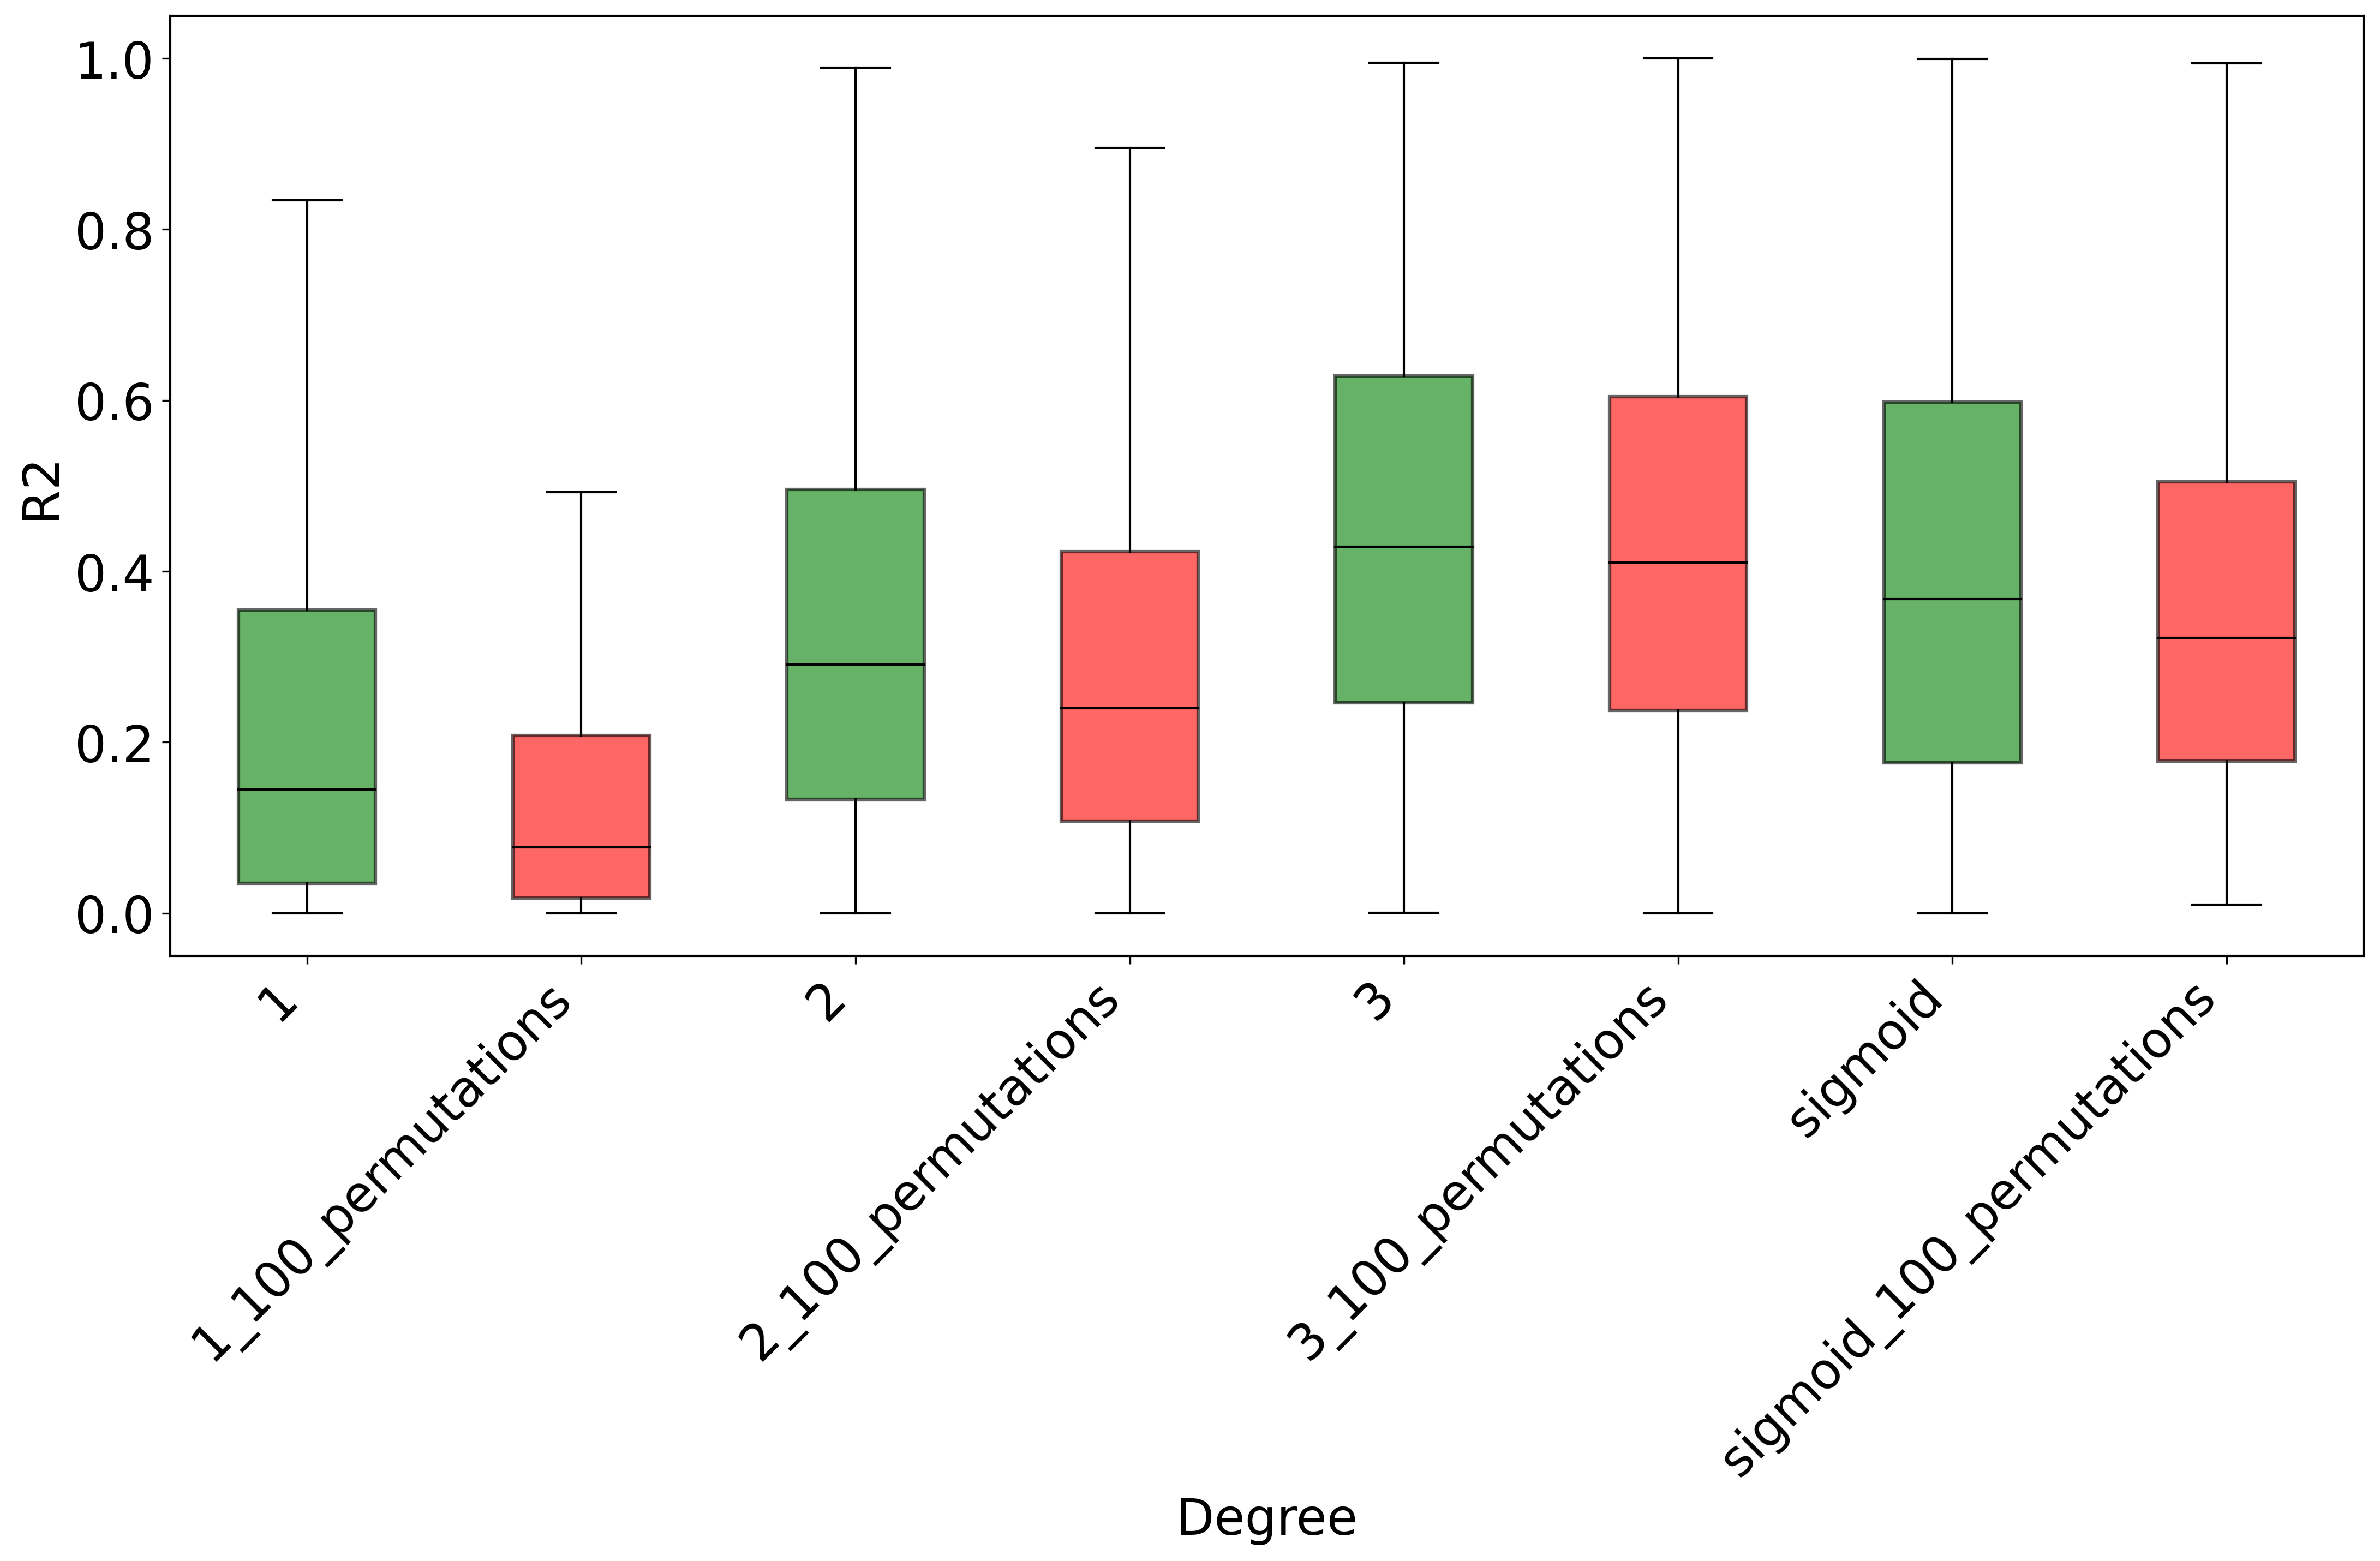

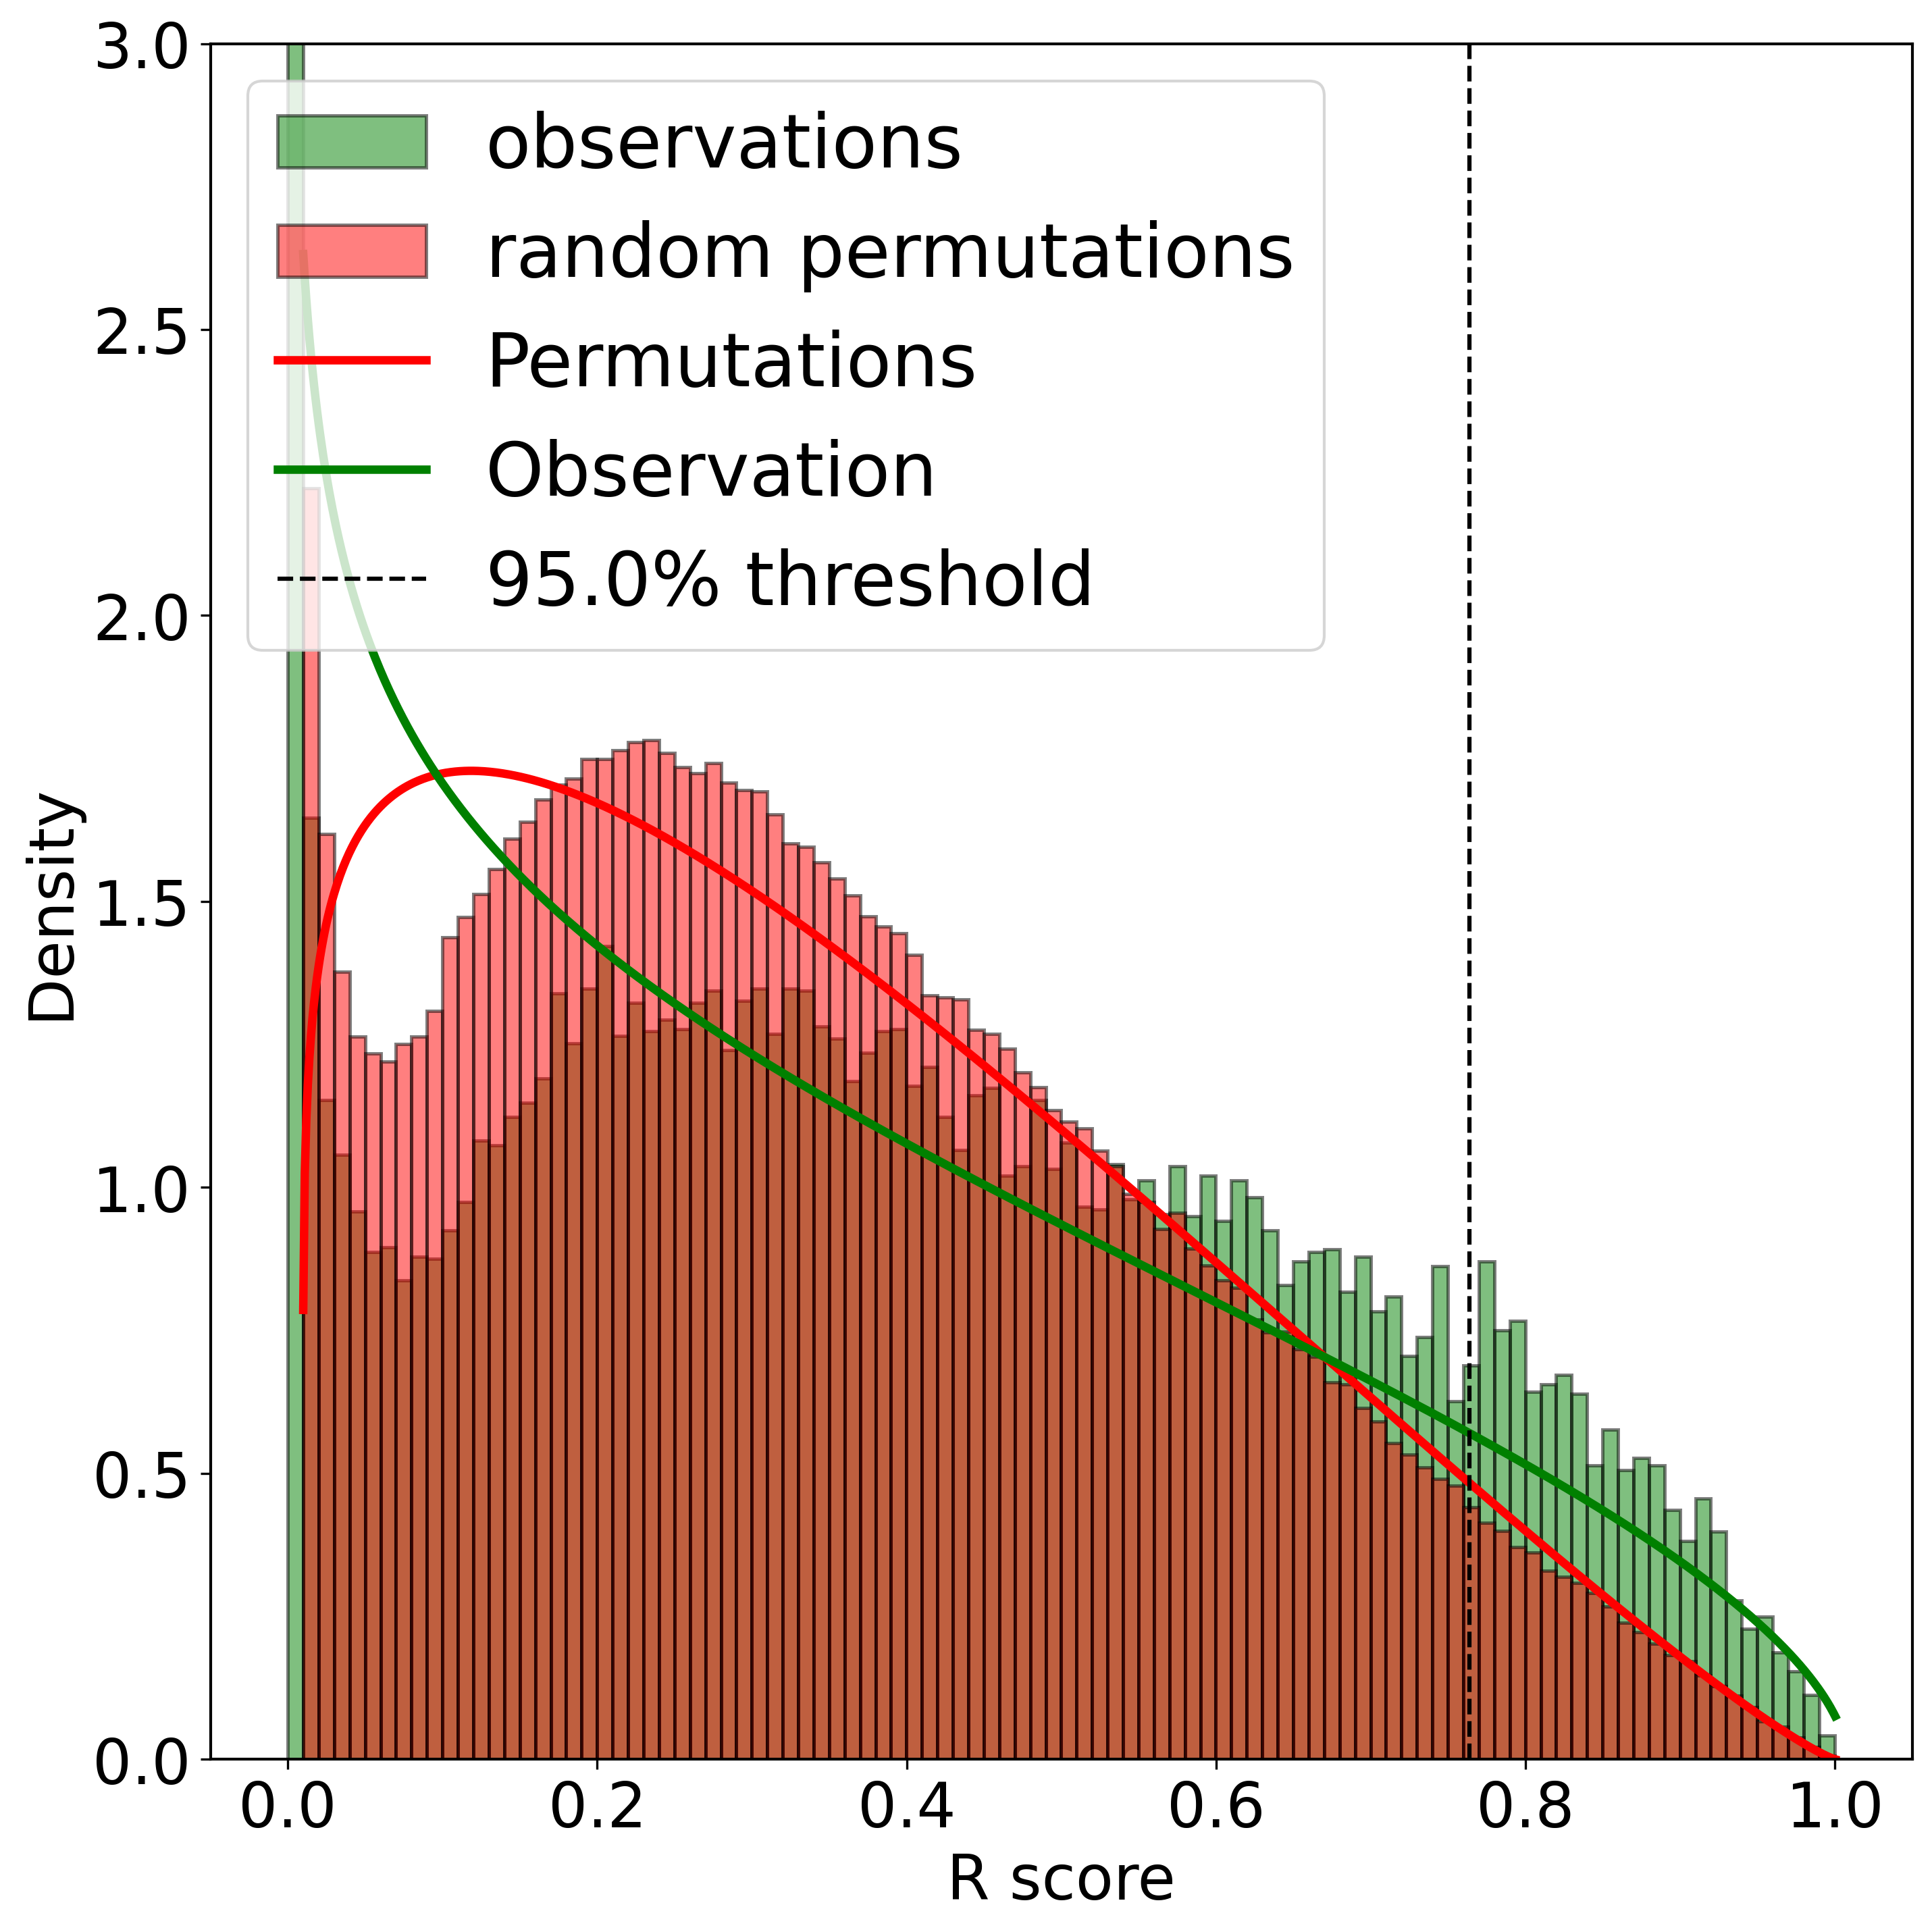

/home/ieo5417/.local/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:639: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


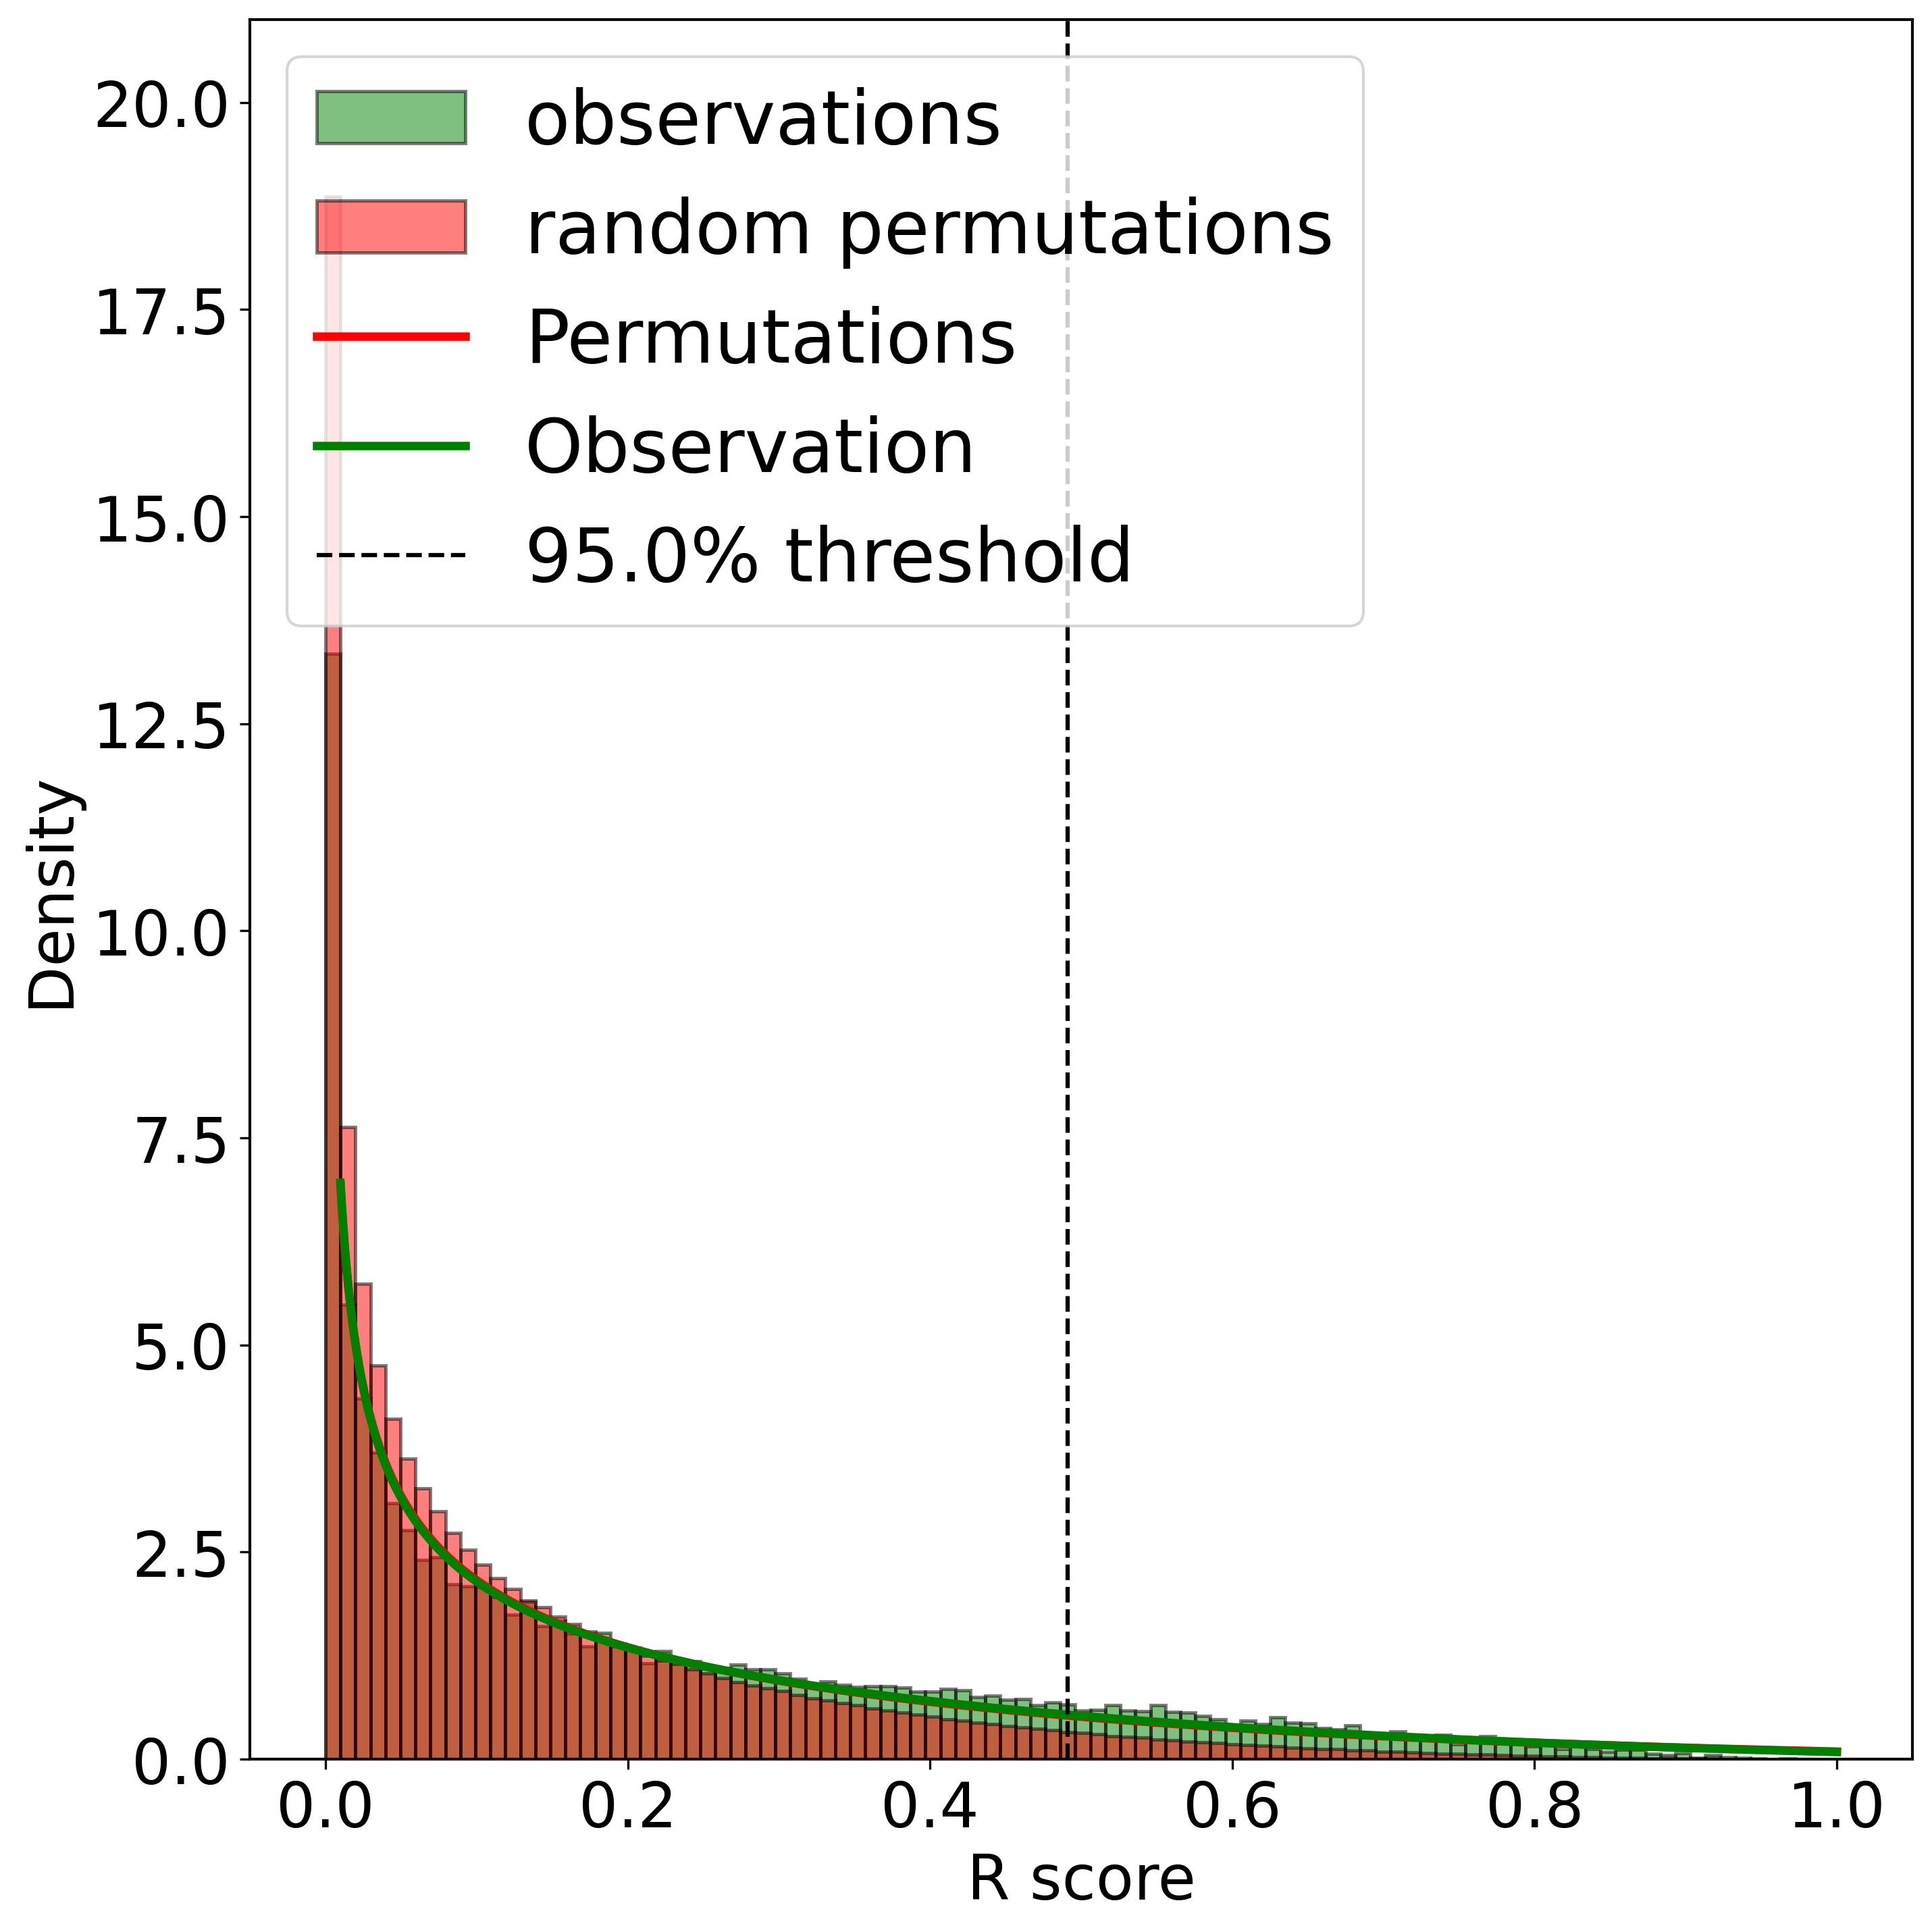

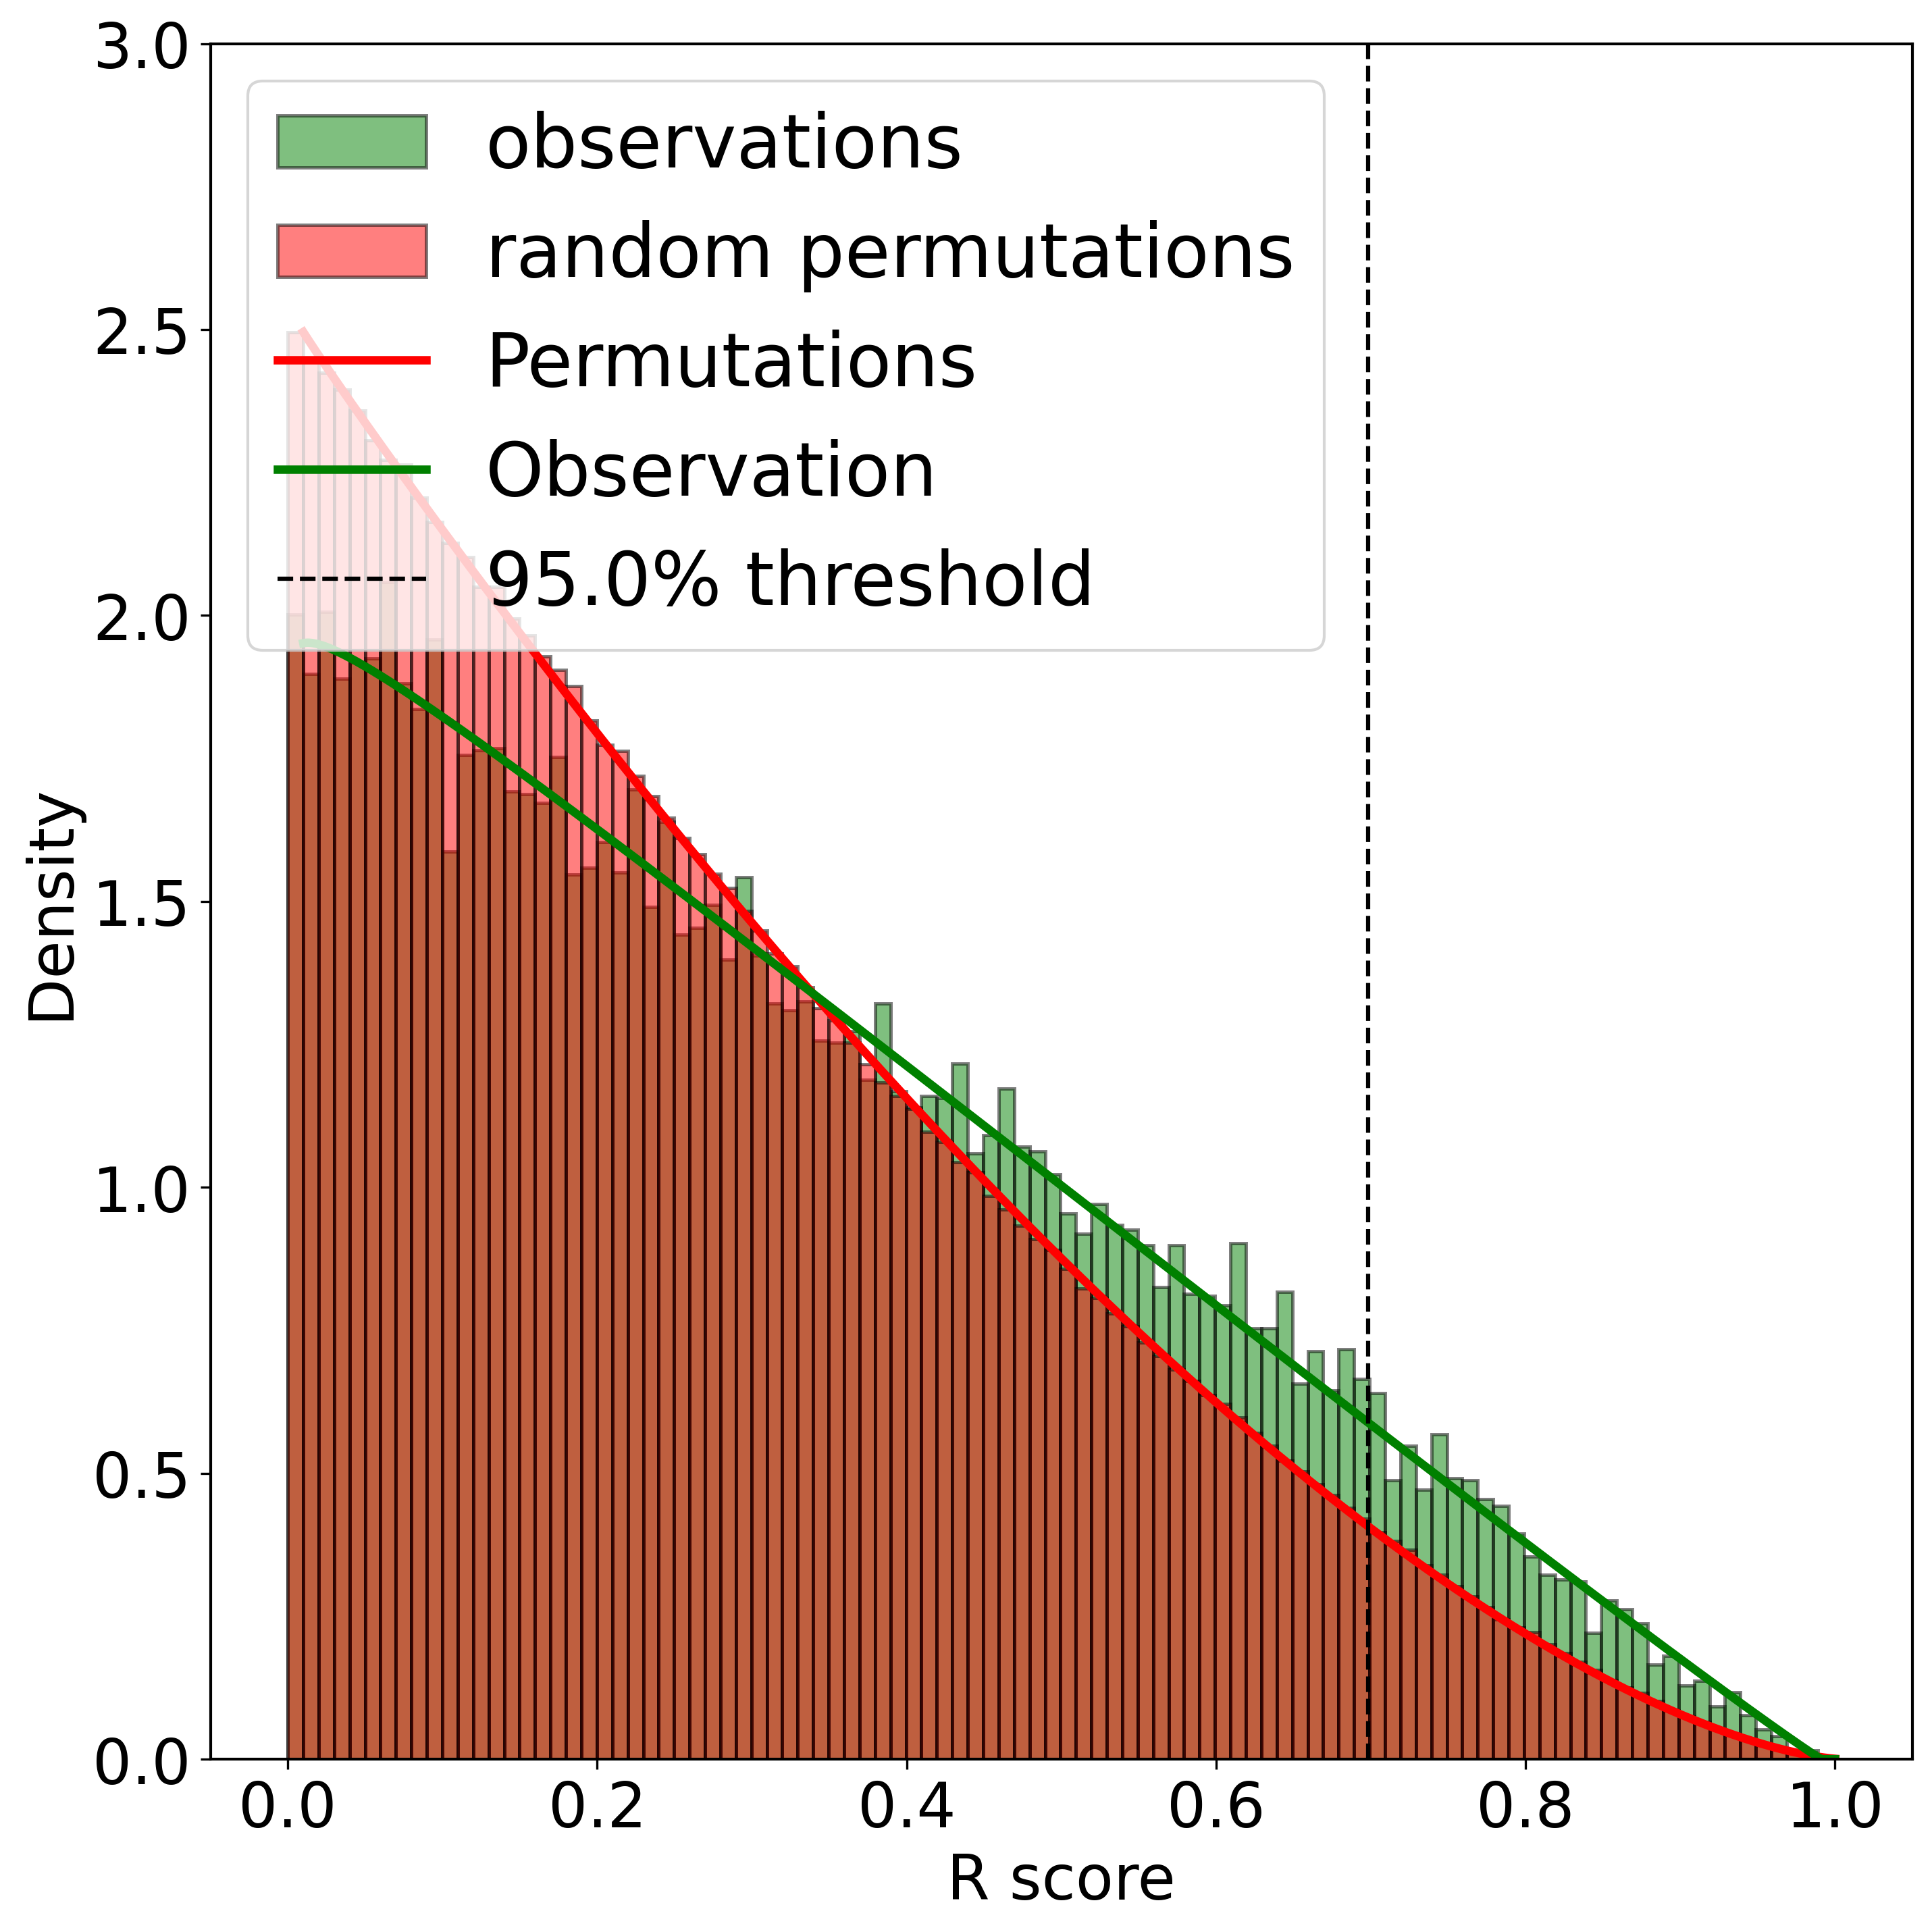

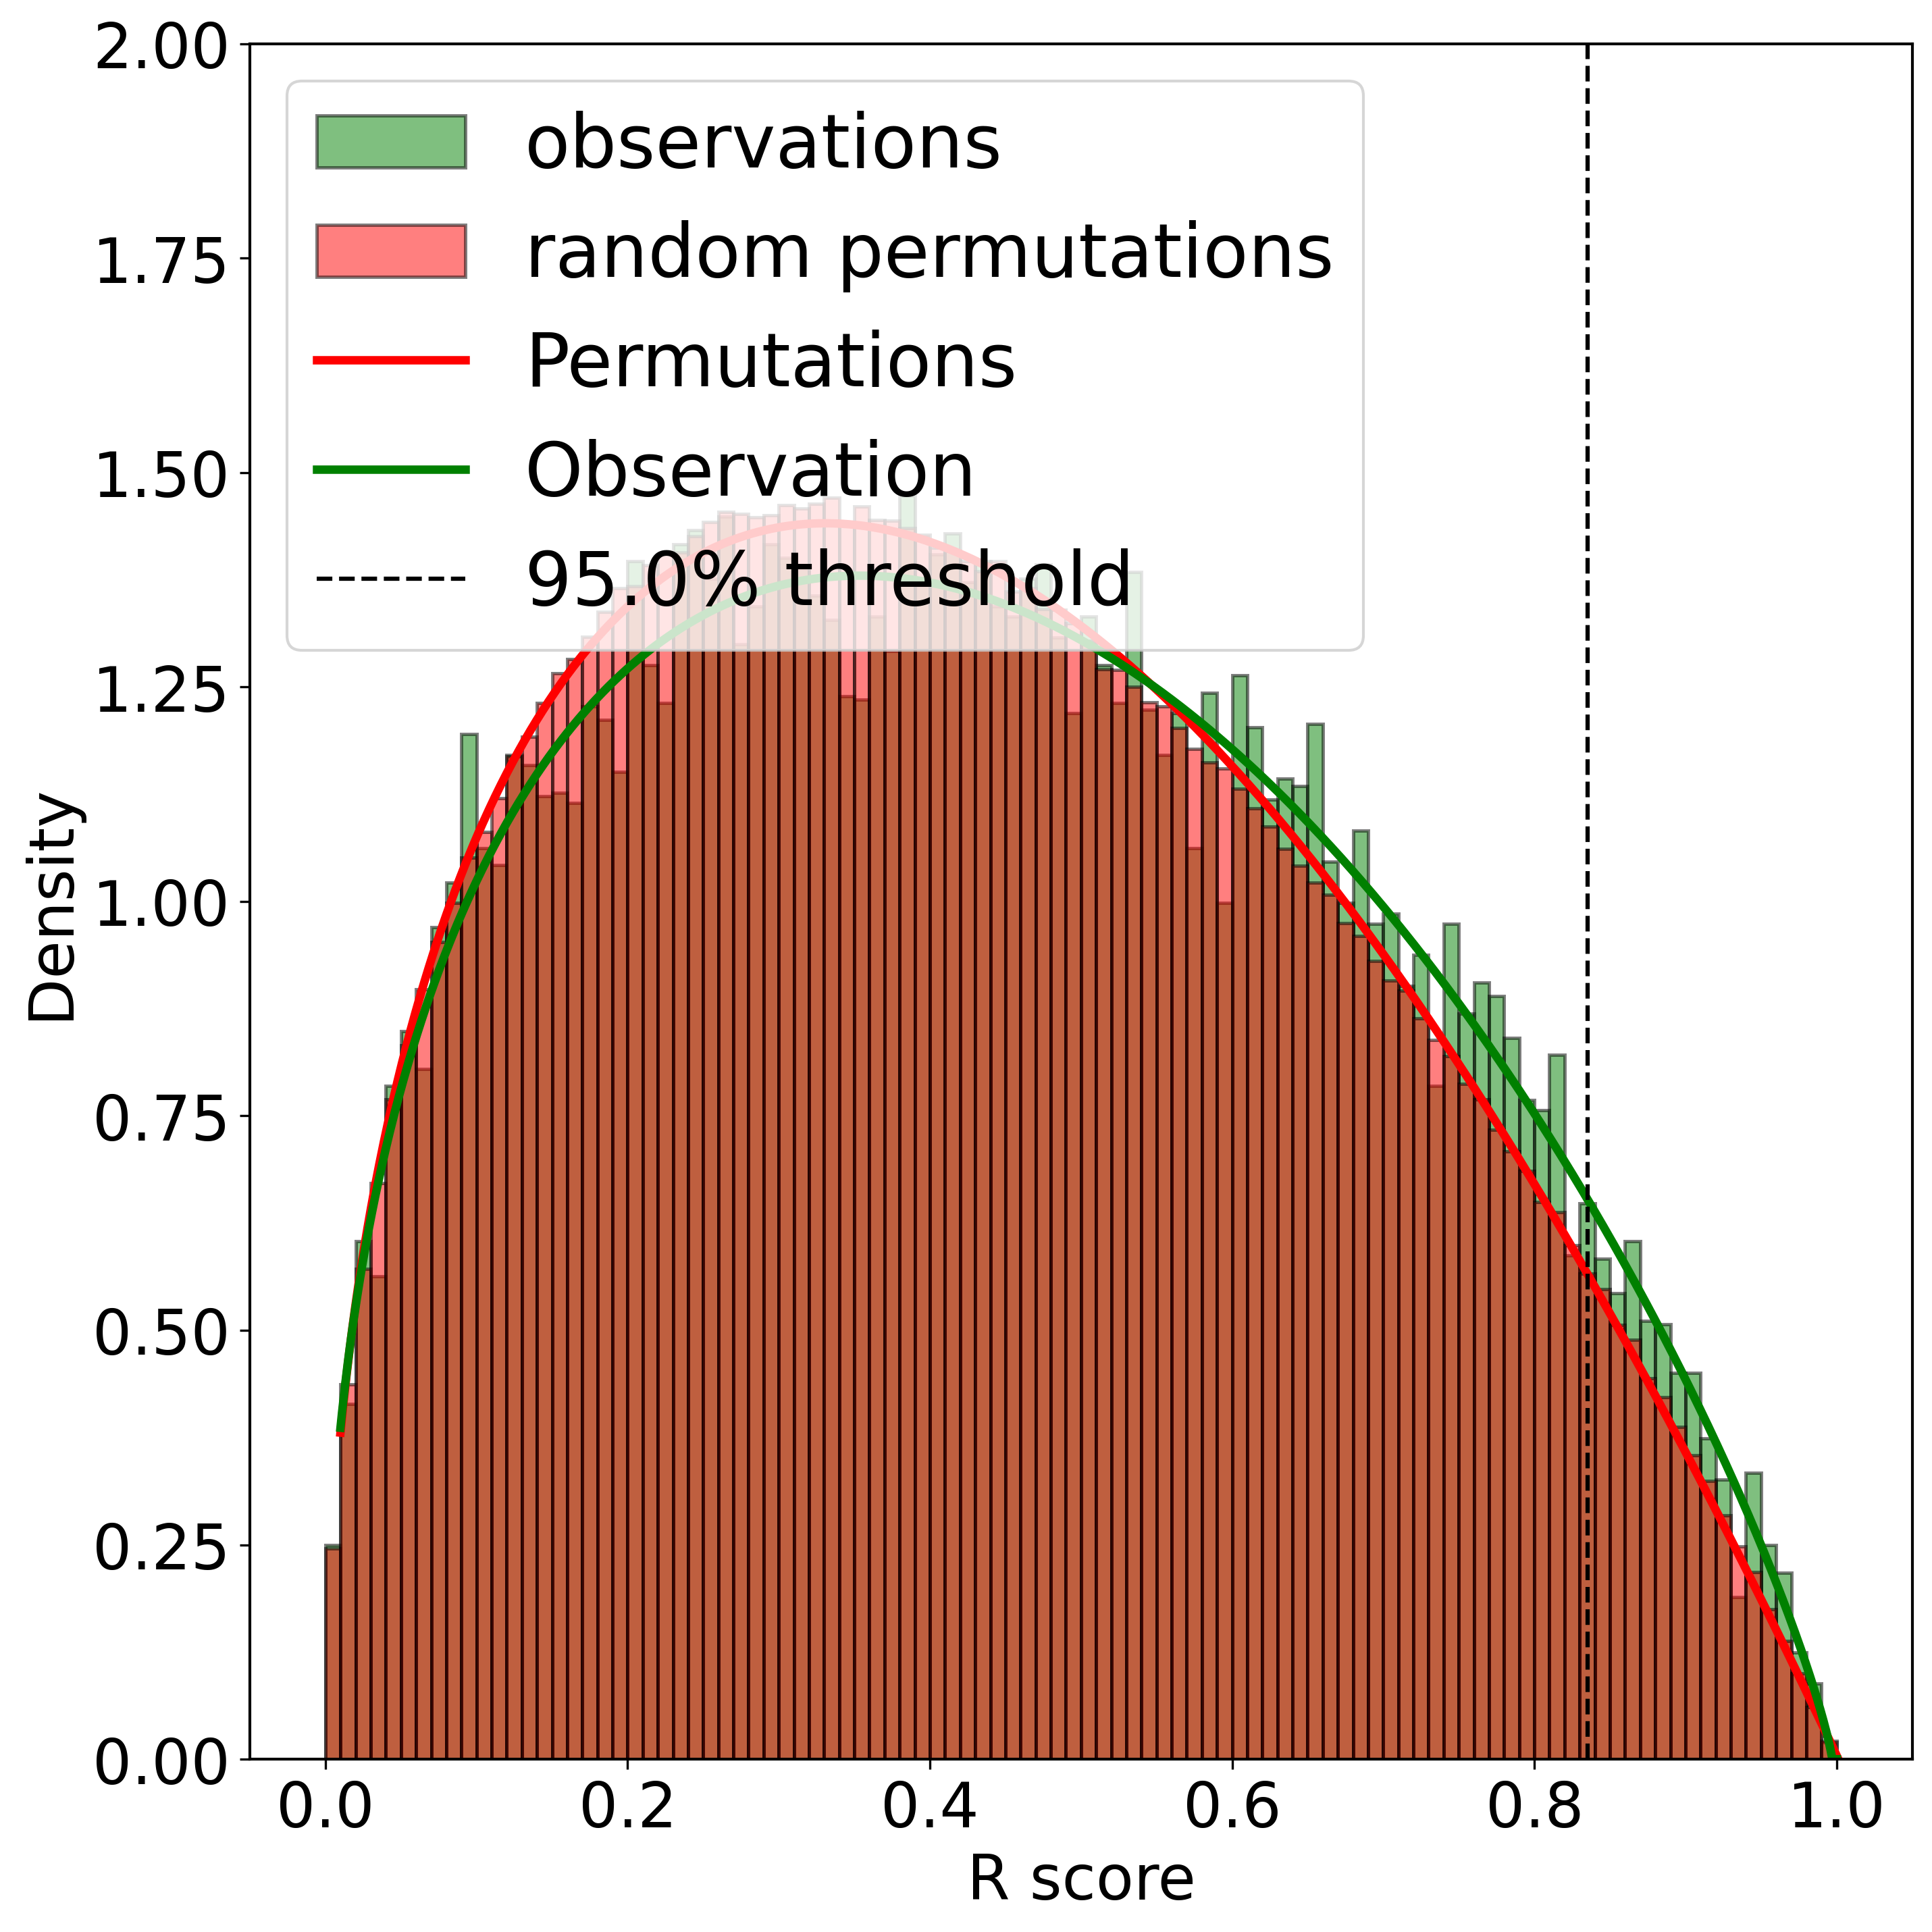

In [27]:
models_pvalue_tr=pa_transcriptome.plot_gof(poly_obs_scores_tr, sig_obs_scores_tr, poly_perm_scores_tr, sig_perm_scores_tr, dist_obs=True, dist_perm=True)

In [28]:
models_pvalue_tr

{'sigmoidal': [27991544945.0, 5.645448405547989e-81, 0.7638648097697223],
 1: [37236394548.0, 0.0, 0.49100631201580486],
 2: [34297705216.0, 1.4070971370627024e-197, 0.6981166202806701],
 3: [31924314722.0, 5.0130851237199393e-20, 0.8349099588242126]}

## Cluster genes

In [29]:
genes_clusters_tr=pa_transcriptome.cluster_genes(scores_tr)

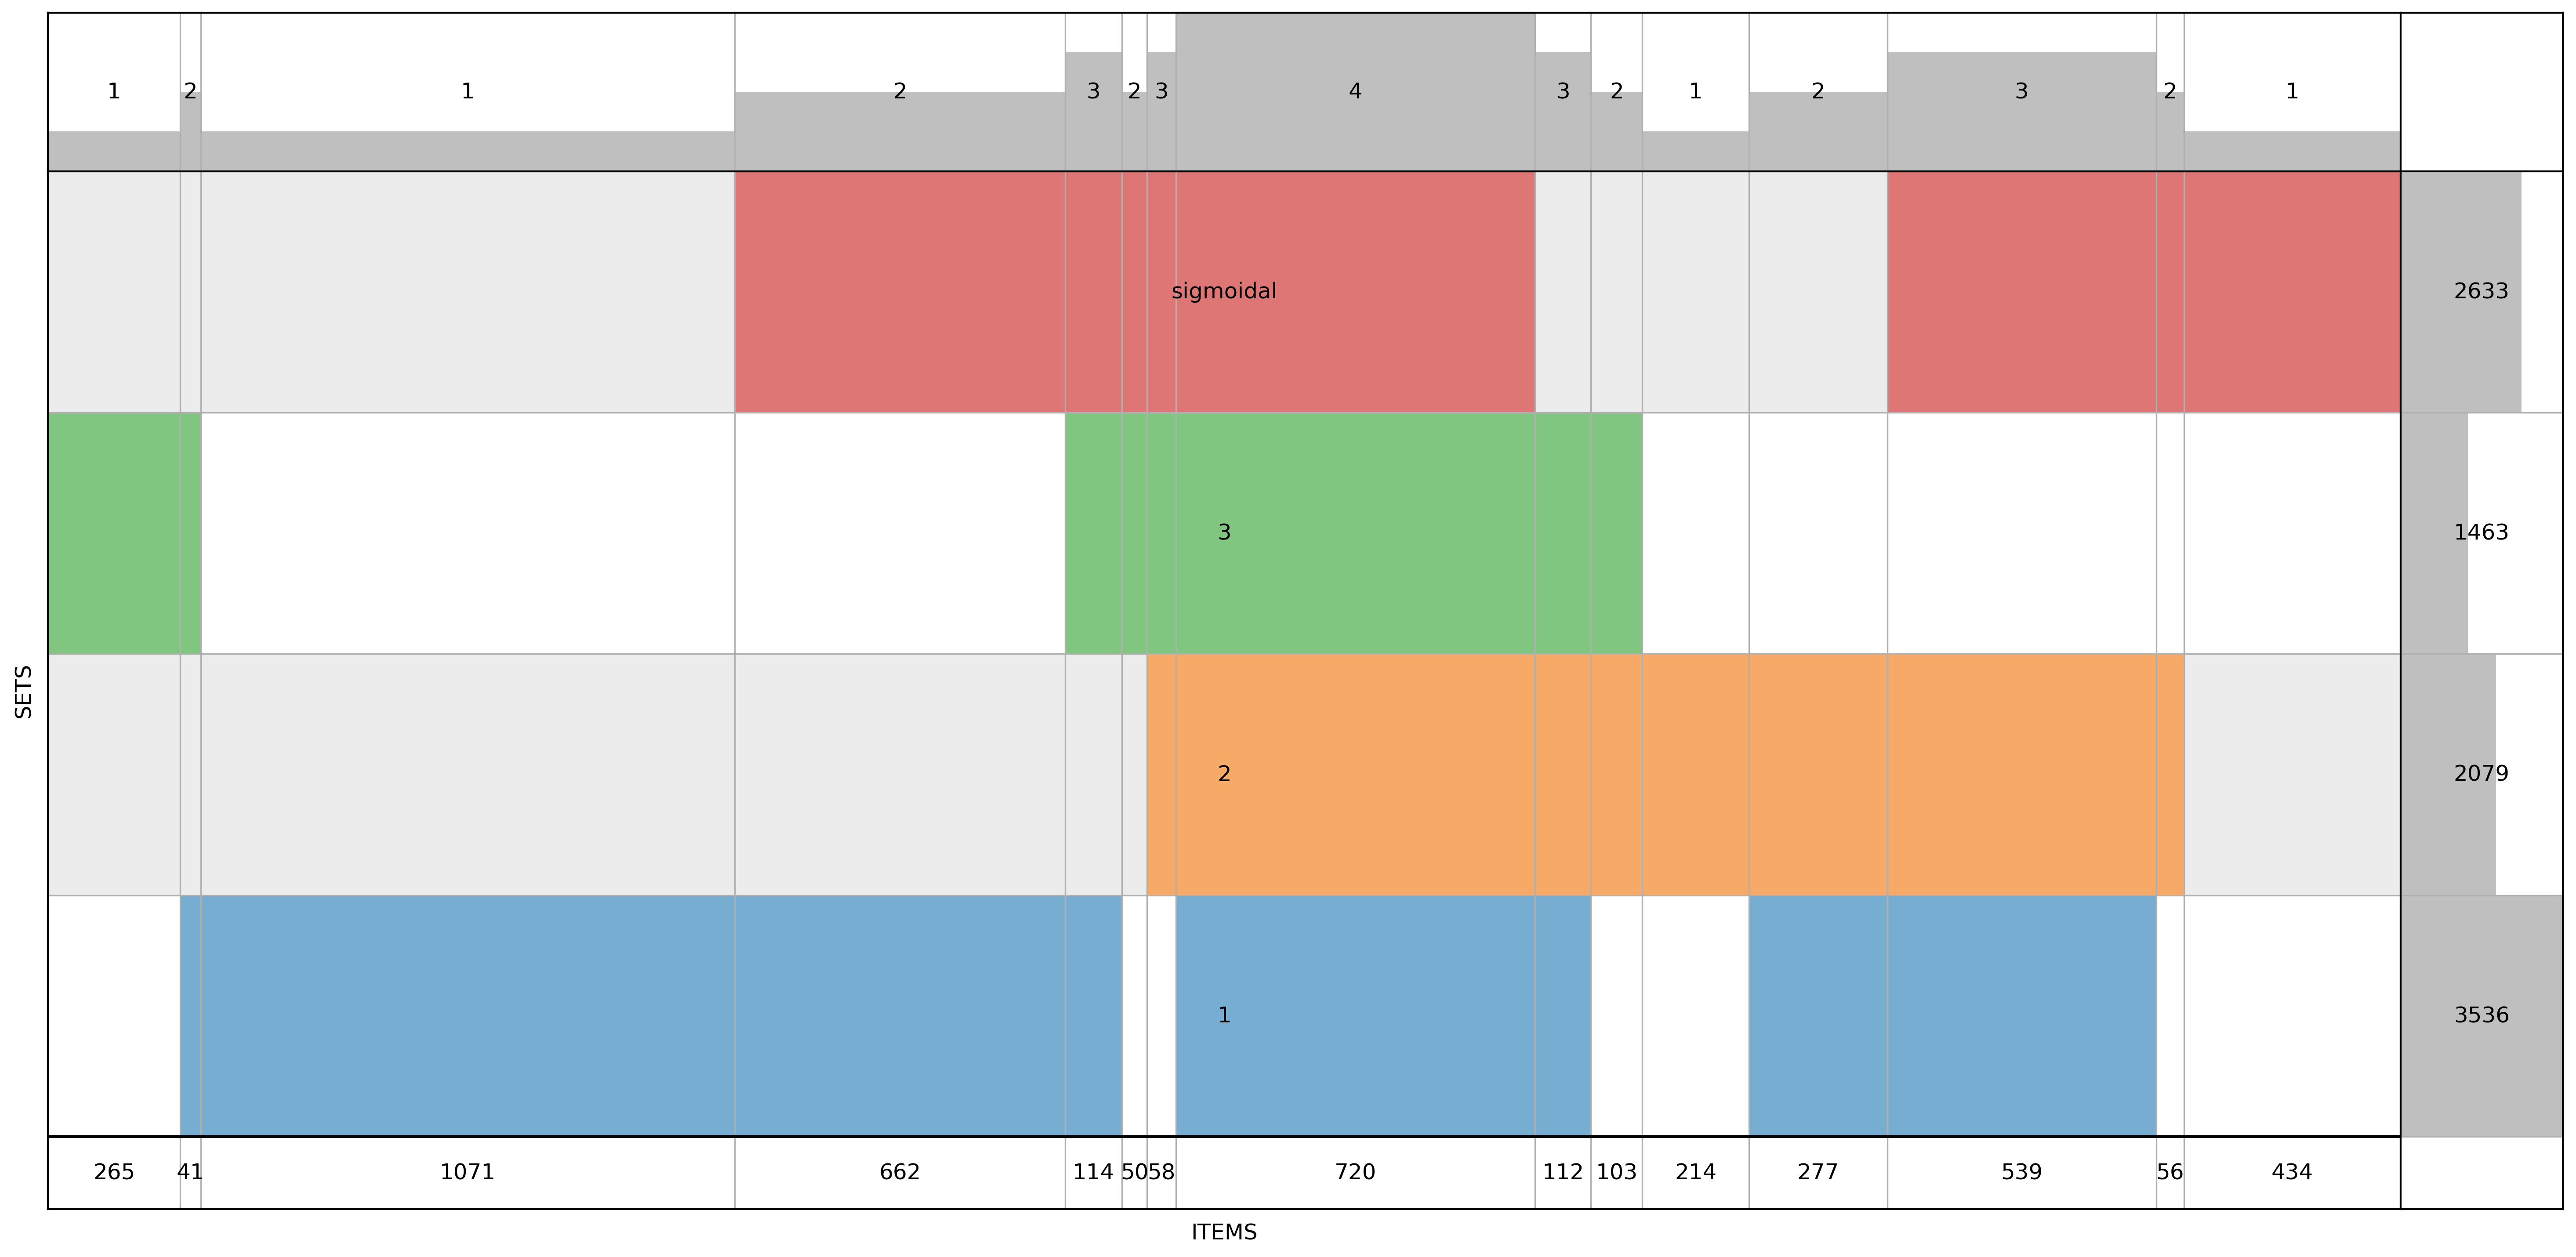

In [30]:
pa_transcriptome.plot_clusters(genes_clusters_tr)

In [31]:
summary_tr=pa_transcriptome.get_summary_table(genes_clusters_tr, scores_tr)

In [32]:
continuum_tr, sigmoid_tr, discarded_tr = pa_transcriptome.classify_genes(summary_tr)

## PLOT PROFILE OF GENES FOUND IN CLOSE PROXIMITY TO CRC METABOLITES O LINKED GLYCOSILATION AND EXTRACELLULA MATRIX ORGANIZATION

In [ ]:
pa_transcriptome.plot_fitting(continuum_tr, ['ENSG00000179913',
'ENSG00000156966',
'ENSG00000169894',
'ENSG00000157350',
'ENSG00000073849',
'ENSG00000126091',
'ENSG00000100626',
'ENSG00000136378',
'ENSG00000092758',
'ENSG00000106397',
'ENSG00000206384',
'ENSG00000049089',
'ENSG00000237172',
'ENSG00000187210',
'ENSG00000141429',
'ENSG00000176597'], medians_tr, poly_models_tr, sig_models_tr, 'continuum', save_as='glyco_matrix_cont_genes.svg')

In [ ]:
sig_models_tr

In [ ]:
poly_models_tr[1]

In [ ]:
sigmoid_tr

## Plot distribution of inflexion points for sigmoid genes

<lambdifygenerated-2>:3: RuntimeWarning: overflow encountered in double_scalars
  return (c*k*exp(-k*(x - x0))/(1 + exp(-k*(x - x0)))**2)
<lambdifygenerated-2>:3: RuntimeWarning: overflow encountered in exp
  return (c*k*exp(-k*(x - x0))/(1 + exp(-k*(x - x0)))**2)
<lambdifygenerated-2>:3: RuntimeWarning: invalid value encountered in double_scalars
  return (c*k*exp(-k*(x - x0))/(1 + exp(-k*(x - x0)))**2)


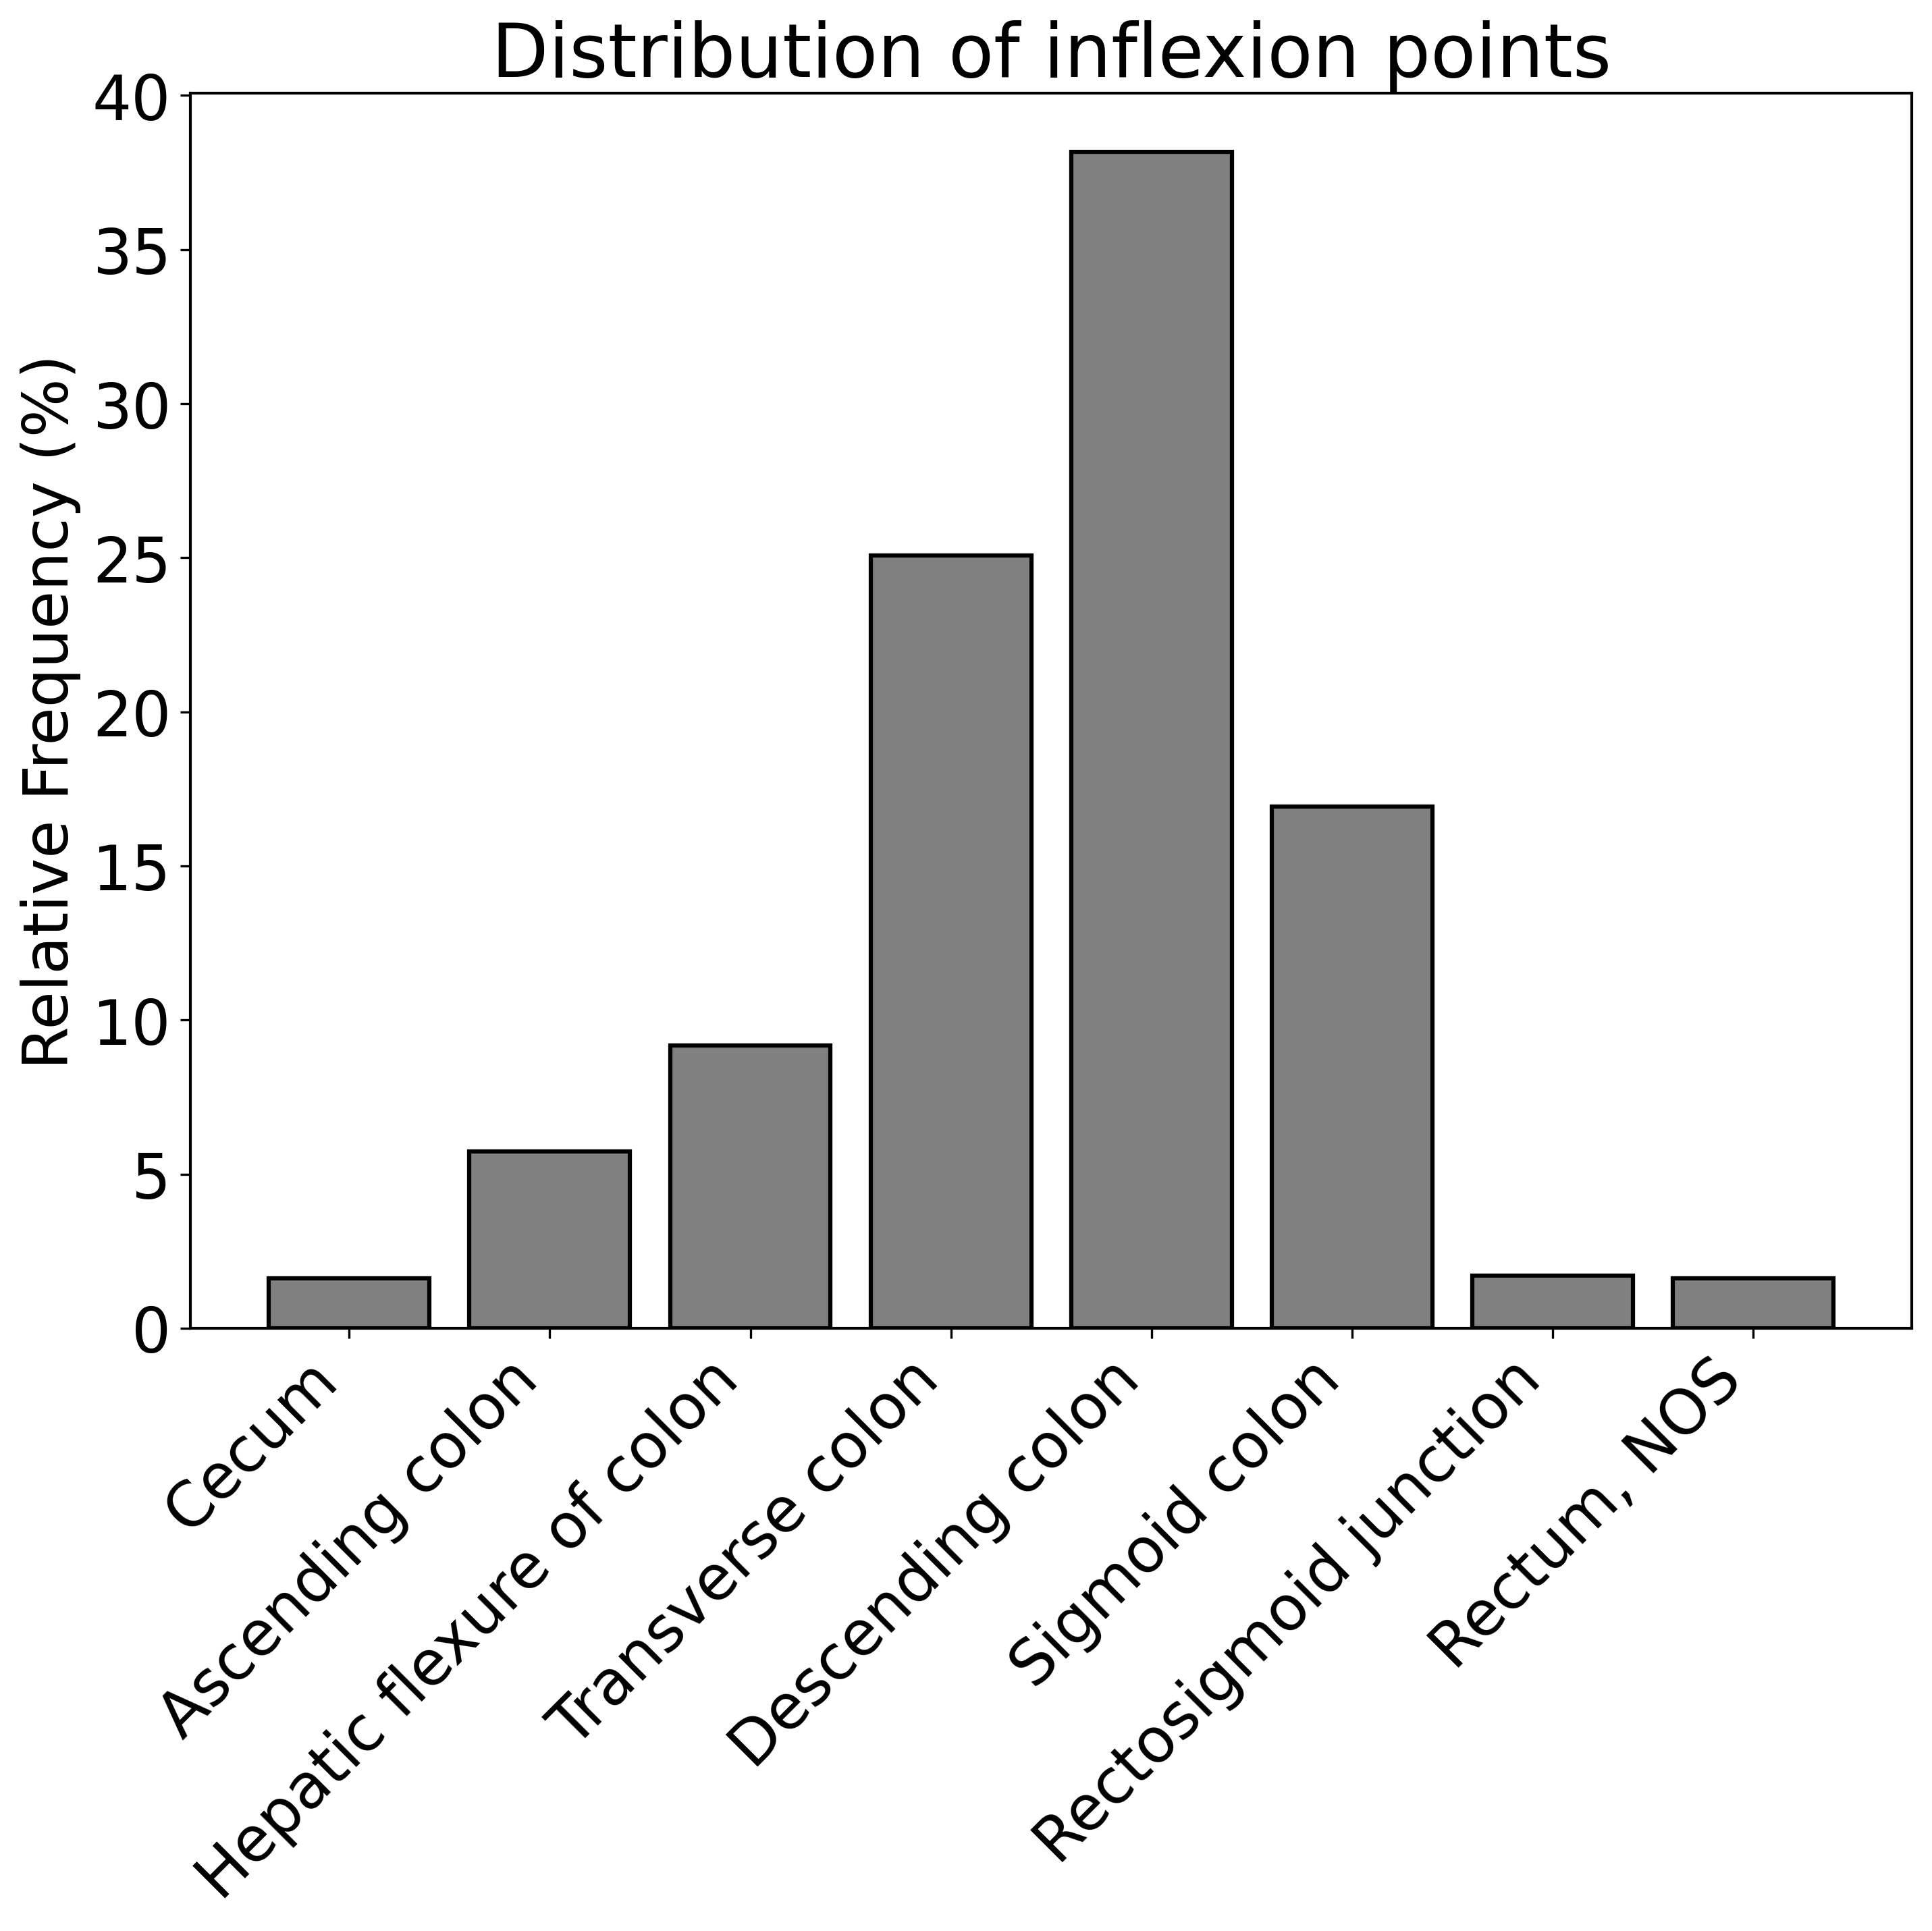

In [33]:
gene_list_tr, section_l_tr = pa_transcriptome.strict_sig_list(sigmoid_tr, sig_models_tr, plot_dist = True)

In [ ]:
from collections import Counter
counts = Counter(section_l_tr)
counts1 = Counter(section_l)
import scipy.stats as scs
chi_table=pd.DataFrame()
sections = ['Cecum','Ascending colon','Hepatic flexure of colon','Transverse colon','Descending colon','Sigmoid colon','Rectosigmoid junction','Rectum, NOS']
for key in sections:
    if key in counts:
        chi_table.loc[key,'observed']=counts[key]
    else:
        chi_table.loc[key,'observed']=0
    chi_table.loc[key,'random']=counts1[key]
scs.chi2_contingency(chi_table)

## Plot distribution of inflexion points for random permutation

<lambdifygenerated-2>:3: RuntimeWarning: overflow encountered in double_scalars
  return (c*k*exp(-k*(x - x0))/(1 + exp(-k*(x - x0)))**2)
<lambdifygenerated-2>:3: RuntimeWarning: overflow encountered in exp
  return (c*k*exp(-k*(x - x0))/(1 + exp(-k*(x - x0)))**2)
<lambdifygenerated-2>:3: RuntimeWarning: invalid value encountered in double_scalars
  return (c*k*exp(-k*(x - x0))/(1 + exp(-k*(x - x0)))**2)


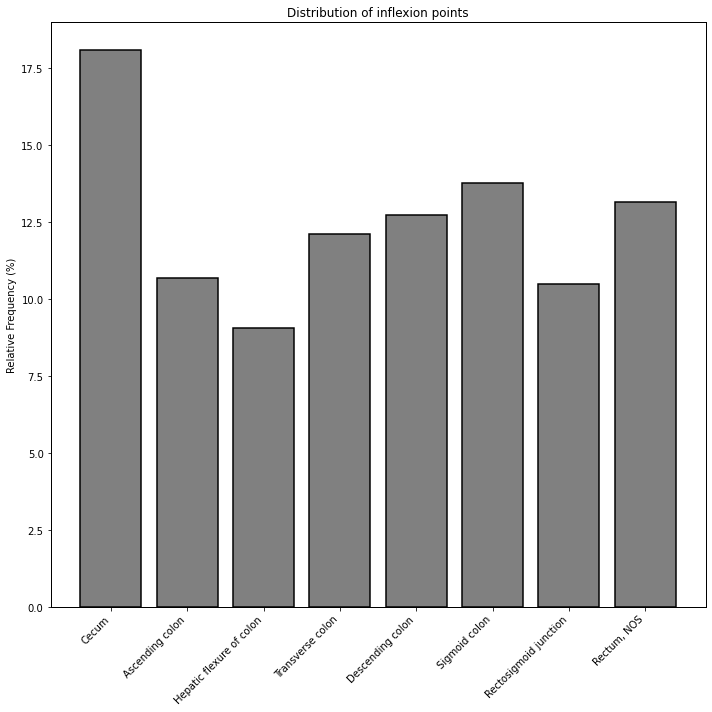

In [11]:
pa_transcriptome.random_model_inflexion(sig_perm_models_tr)

# METHYLOME PROFILING

In [ ]:
# Create workflow class, specifying the path to the SETTINGS.ini file
pa_methylome = ProfileAnalysis('../../../docker/analysis/methylome')

## Assign each sample in clinical data file to a colon section

In [ ]:
pa_methylome.create_samples_to_sections_table()

In [ ]:
pa_methylome.plot_sample_distribution()

## Calculate median value for each colon section

In [ ]:
medians_meth, mad_meth = pa_methylome.median_by_section()

In [ ]:
medians_meth.head()

In [ ]:
mad_meth.head()

## Fit Observables

In [ ]:
scores_meth, poly_obs_scores_meth, sig_obs_scores_meth, poly_models_meth, sig_models_meth = pa_methylome.fit_data(medians_meth, guess_bounds = True)

## Fit Random permutated data

In [ ]:
poly_perm_scores_meth, sig_perm_scores_meth, sig_perm_models_meth=pa_methylome.fit_random_data(medians_meth, guess_bounds = True)

## Compare obrservable vs permutated data

In [ ]:
models_pvalue_meth=pa_methylome.plot_gof(poly_obs_scores_meth, sig_obs_scores_meth, poly_perm_scores_meth, sig_perm_scores_meth, dist_obs=False, dist_perm=False)

In [ ]:
models_pvalue_meth

## Cluster genes

In [ ]:
genes_clusters_meth=pa_methylome.cluster_genes(scores_meth)

In [ ]:
pa_methylome.plot_clusters(genes_clusters_meth)

In [ ]:
summary_meth=pa_methylome.get_summary_table(genes_clusters_meth, scores_meth)

In [ ]:
continuum_meth, sigmoid_meth, discarded_meth = pa_methylome.classify_genes(summary_meth)

In [ ]:
continuum_meth

## Plot distribution of inflexion points for sigmoid genes

In [ ]:
gene_list_meth, section_l_meth = pa_methylome.strict_sig_list(sigmoid_meth, sig_models_meth, plot_dist = True)

In [ ]:
from collections import Counter
counts = Counter(section_l_meth)
counts1 = Counter(section_l)
import scipy.stats as scs
chi_table=pd.DataFrame()
sections = ['Cecum','Ascending colon','Hepatic flexure of colon','Transverse colon','Descending colon','Sigmoid colon','Rectosigmoid junction','Rectum, NOS']
for key in sections:
    if key in counts:
        chi_table.loc[key,'observed']=counts[key]
    else:
        chi_table.loc[key,'observed']=0
    chi_table.loc[key,'random']=counts1[key]
scs.chi2_contingency(chi_table)

## Plot distribution of inflexion points for random permutation

In [ ]:
pa_methylome.strict_sig_list_random(medians_meth, mad_meth, sigmoid_meth, sig_models_meth, plot_dist = True)

# OVERLAP BETWEEN TRANSCRIPTOMIC AND METHYLATION DATA

## continuum

In [ ]:
gene_list = set([i.split('_')[0] for i in list(continuum_meth.index)])
query = mg.querymany(gene_list,
                      scopes='symbol',
                      species=9606,
                      fields='ensembl',
                      returnall=True)
meth_ensmbl = []
for element in query['out']:
    if 'ensembl' in element:
        entry = element['ensembl']
        if type(entry) is list:
            for sub_element in entry:
                meth_ensmbl.append(sub_element['gene'])
        else:
            meth_ensmbl.append(entry['gene'])

In [ ]:
clusters = [set(continuum_tr.index), meth_ensmbl]
labels = ['transcriptomic', 'methylation']
plt.figure(figsize=(20, 10))
supervenn(clusters, labels)

## sigmoid

In [ ]:
gene_list = set([i.split('_')[0] for i in list(sigmoid_meth.index)])
query = mg.querymany(gene_list,
                      scopes='symbol',
                      species=9606,
                      fields='ensembl',
                      returnall=True)
meth_ensmbl = []
for element in query['out']:
    if 'ensembl' in element:
        entry = element['ensembl']
        if type(entry) is list:
            for sub_element in entry:
                meth_ensmbl.append(sub_element['gene'])
        else:
            meth_ensmbl.append(entry['gene'])

In [ ]:
clusters = [set(sigmoid_tr.index), meth_ensmbl]
labels = ['transcriptomic', 'methylation']
plt.figure(figsize=(20, 10))
supervenn(clusters, labels)

# OVERLAP WITH METHYLDRIVER

In [ ]:
trend = list(set([i.split('_')[0] for i in list(continuum_meth.index)]))
trend= trend +list(set([i.split('_')[0] for i in list(sigmoid_meth.index)]))
diff_methylated = pd.read_csv('/home/ieo5417/Documenti/colon_paper/docker/analysis/methyldriver/COAD_hyper_hypo_methylated_genes.csv')
diff_methylated.set_index('gene_symbol', inplace=True)


In [ ]:
no_hypo=pd.DataFrame(columns=['genes'])
all_r_genes=pd.read_csv('/home/ieo5417/Documenti/colon_paper/docker/analysis/methyldriver/all_richards_genes.csv')
for index,row in all_r_genes.iterrows():
    if row['genes'] not in diff_methylated.index:
          no_hypo.loc[index]=row
no_hypo.set_index('genes', inplace=True)

In [ ]:
for index, row in medians_meth.iterrows():
    medians_meth.loc[index, 'gene'] = index.split('_')[0]
medians_meth.set_index('gene', inplace=True)

In [ ]:
medians_meth = medians_meth[~medians_meth.index.duplicated(keep='first')]

In [ ]:
trend_df=pd.DataFrame(trend, columns=['genes'])
trend_df.set_index('genes', inplace=True)
no_trend=medians_meth.merge(trend_df, left_index=True, right_index=True, how='outer', indicator=True)
no_trend=no_trend[no_trend['_merge']=='left_only']

In [ ]:
no_trend.merge(no_hypo, left_index=True, right_index=True, how='inner')

In [ ]:
trend_df.merge(no_hypo, left_index=True, right_index=True, how='inner')

In [ ]:
cont_df = pd.DataFrame(list(set([i.split('_')[0] for i in list(continuum_meth.index)])), columns=['gene'])
cont_df.set_index('gene', inplace=True)

In [ ]:
cont_df.merge(diff_methylated, how='inner', left_index=True, right_index=True)

In [ ]:
sig_df = pd.DataFrame(list(set([i.split('_')[0] for i in list(sigmoid_meth.index)])), columns=['gene'])
sig_df.set_index('gene', inplace=True)
sig_df.merge(diff_methylated, how='inner', left_index=True, right_index=True)

In [ ]:
import numpy as np
table = np.array([[106, 3873], [65, 10431]])
from scipy.stats import fisher_exact
oddsr, p = fisher_exact(table, alternative='two-sided')
p

# MUTATIONS PROFILING

In [ ]:
# Create workflow class, specifying the path to the SETTINGS.ini file
pa_mutations = ProfileAnalysis('../../../docker/analysis/mutations')

## Assign each sample in clinical data file to a colon section

## Calculate median value for each colon section

In [ ]:
medians_tr, mad_tr = pa_mutations.median_by_section()

In [ ]:
# medians_tr = medians_tr[(medians_tr == 0).sum(1) < 1]
medians_tr

In [ ]:
pa_mutations.print_settings()

## Fit Observables

In [ ]:
scores_tr, poly_obs_scores_tr, sig_obs_scores_tr, poly_models_tr, sig_models_tr = pa_mutations.fit_data(medians_tr, guess_bounds = True)

## Fit Random permutated data

In [ ]:
poly_perm_scores_tr, sig_perm_scores_tr, sig_perm_models_tr=pa_mutations.fit_random_data(medians_tr, guess_bounds = False)

In [ ]:
section_l = []
x = sym.Symbol('x')
x0 = sym.Symbol('x0')
y0 = sym.Symbol('y0')
c = sym.Symbol('c')
k = sym.Symbol('k')
f = c / (1 + sym.exp(-k*(x-x0))) + y0
f_prime = f.diff(x)
f_prime = sym.lambdify([(x, x0, y0, c, k)], f_prime)
x = np.linspace(pa_mutations.x[0], pa_mutations.x[-1], 2000)
for element in sample(sig_perm_models_tr,500):
    if element[1]!=-999:
        d_ = []
        for i in x:
            d_.append(abs(f_prime(np.insert(element, 0, i))))
        index_min = np.argmax(d_)
        section = list(pa_mutations.sections.keys())[int(round(x[index_min]))-1]
    #     print(np.argmax(d_))
#         if np.argmax(d_) != 0:
        section_l.append(section)
indexes = np.arange(len(pa_mutations.sections))
#         width = 0.3
values = pd.Series(section_l).value_counts().reindex(pa_mutations.sections)/len(section_l)*100
plt.figure(figsize=(10, 10))
plt.bar(indexes, values, edgecolor='k', color='grey', linewidth=1.5)
plt.xticks(indexes, pa_mutations.sections, rotation=45, ha='right')
plt.ylabel('Relative Frequency (%)')
# plt.ylim([0,50])
plt.title('Distribution of inflexion points')
plt.tight_layout()
plt.savefig('/'.join([pa_mutations.figures, 'inflection_distribution_sigmoid_random.svg']), format='svg')

In [ ]:
sig_perm_models_tr

In [ ]:
pa_mutations.t_area=0.99

## Compare obrservable vs permutated data

In [ ]:
models_pvalue_tr=pa_mutations.plot_gof(poly_obs_scores_tr, sig_obs_scores_tr, poly_perm_scores_tr, sig_perm_scores_tr, dist_obs=True, dist_perm=True)

In [ ]:
models_pvalue_tr

## Cluster genes

In [ ]:
genes_clusters_tr=pa_mutations.cluster_genes(scores_tr)

In [ ]:
pa_mutations.plot_clusters(genes_clusters_tr)

In [ ]:
summary_tr=pa_mutations.get_summary_table(genes_clusters_tr, scores_tr)

In [ ]:
continuum_tr, sigmoid_tr, discarded_tr = pa_mutations.classify_genes(summary_tr)

## Plot distribution of inflexion points for sigmoid genes

In [ ]:
gene_list_tr, section_l_tr = pa_mutations.strict_sig_list(sigmoid_tr, sig_models_tr, plot_dist = True)

In [ ]:
section_l_tr

In [ ]:
from collections import Counter
counts = Counter(section_l_tr)
counts1 = Counter(section_l)
import scipy.stats as scs
chi_table=pd.DataFrame()
sections = ['Cecum','Ascending colon','Hepatic flexure of colon','Transverse colon','Descending colon','Sigmoid colon','Rectosigmoid junction','Rectum, NOS']
for key in sections:
    if key in counts:
        chi_table.loc[key,'observed']=counts[key]
    else:
        chi_table.loc[key,'observed']=0
    chi_table.loc[key,'random']=counts1[key]
scs.chi2_contingency(chi_table)

In [ ]:
chi_table

In [ ]:
from scipy.stats import mannwhitneyu
stat, p_value = mannwhitneyu(section_l_tr, section_l)

## Plot distribution of inflexion points for random permutation

In [ ]:
pa_mutations.strict_sig_list_random(medians_tr, mad_tr, sigmoid_tr, sig_models_tr, plot_dist = True)

# ANEUPLOIDY PROFILING

## Duplication

In [ ]:
# Create workflow class, specifying the path to the SETTINGS.ini file
pa_duplication = ProfileAnalysis('../../../docker/analysis/aneuploidy/duplication')

## Assign each sample in clinical data file to a colon section

In [ ]:
pa_duplication.create_samples_to_sections_table()

In [ ]:
pa_duplication.plot_sample_distribution()

## Calculate median value for each colon section

In [ ]:
medians_tr, mad_tr = pa_duplication.median_by_section()

In [ ]:
medians_tr=medians_tr[(medians_tr==0).sum(axis=1)<4]

## Fit Observables

In [ ]:
scores_tr, poly_obs_scores_tr, sig_obs_scores_tr, poly_models_tr, sig_models_tr = pa_duplication.fit_data(medians_tr, guess_bounds = True)

In [ ]:
scores_tr.head()

## Fit Random permutated data

In [ ]:
poly_perm_scores_tr, sig_perm_scores_tr=pa_duplication.fit_random_data(medians_tr, guess_bounds = True)

## Compare obrservable vs permutated data

In [ ]:
models_pvalue_tr=pa_duplication.plot_gof(poly_obs_scores_tr, sig_obs_scores_tr, poly_perm_scores_tr, sig_perm_scores_tr, dist_obs=False, dist_perm=False)

In [ ]:
models_pvalue_tr

## Cluster genes

In [ ]:
genes_clusters_tr=pa_duplication.cluster_genes(scores_tr)

In [ ]:
pa_duplication.plot_clusters(genes_clusters_tr)

In [ ]:
summary_tr=pa_duplication.get_summary_table(genes_clusters_tr, scores_tr)

In [ ]:
continuum_tr, sigmoid_tr, discarded_tr = pa_duplication.classify_genes(summary_tr)

In [ ]:
continuum_tr

In [ ]:
sigmoid_tr

In [ ]:
pa_duplication.plot_fitting(continuum_tr, continuum_tr.index, medians_tr, poly_models_tr, sig_models_tr, 'continuum')

## Plot distribution of inflexion points for sigmoid genes

In [ ]:
if not sigmoid_tr.empty:
    gene_list_tr, section_l_tr = pa_duplication.strict_sig_list(sigmoid_tr, sig_models_tr, plot_dist = True)

## Plot distribution of inflexion points for random permutation

In [ ]:
if not sigmoid_tr.empty:
    pa_duplication.strict_sig_list_random(medians_tr, mad_tr, sigmoid_tr, sig_models_tr, plot_dist = True)

## Deletion

In [ ]:
# Create workflow class, specifying the path to the SETTINGS.ini file
pa_deletion = ProfileAnalysis('../../../docker/analysis/aneuploidy/deletion')

## Assign each sample in clinical data file to a colon section

In [ ]:
pa_deletion.create_samples_to_sections_table()

In [ ]:
pa_deletion.plot_sample_distribution()

## Calculate median value for each colon section

In [ ]:
medians_tr, mad_tr = pa_deletion.median_by_section()

In [ ]:
medians_tr=medians_tr[(medians_tr==0).sum(axis=1)<4]

In [ ]:
medians_tr.head()

## Fit Observables

In [ ]:
scores_tr, poly_obs_scores_tr, sig_obs_scores_tr, poly_models_tr, sig_models_tr = pa_deletion.fit_data(medians_tr, guess_bounds = True)

In [ ]:
scores_tr.head()

## Fit Random permutated data

In [ ]:
poly_perm_scores_tr, sig_perm_scores_tr=pa_deletion.fit_random_data(medians_tr, guess_bounds = True)

## Compare obrservable vs permutated data

In [ ]:
models_pvalue_tr=pa_deletion.plot_gof(poly_obs_scores_tr, sig_obs_scores_tr, poly_perm_scores_tr, sig_perm_scores_tr, dist_obs=False, dist_perm=False)

In [ ]:
models_pvalue_tr

 If you have time we can ## Cluster genes

In [ ]:
genes_clusters_tr=pa_deletion.cluster_genes(scores_tr)

In [ ]:
pa_deletion.plot_clusters(genes_clusters_tr)

In [ ]:
summary_tr=pa_deletion.get_summary_table(genes_clusters_tr, scores_tr)

In [ ]:
continuum_tr, sigmoid_tr, discarded_tr = pa_deletion.classify_genes(summary_tr)

In [ ]:
continuum_tr

In [ ]:
sigmoid_tr

In [ ]:
pa_duplication.plot_fitting(continuum_tr, continuum_tr.index, medians_tr, poly_models_tr, sig_models_tr, 'continuum')

In [ ]:
pa_duplication.plot_fitting(sigmoid_tr, sigmoid_tr.index, medians_tr, poly_models_tr, sig_models_tr, 'sigmoid')

## Plot distribution of inflexion points for sigmoid genes

In [ ]:
if not sigmoid_tr.empty:
    gene_list_tr, section_l_tr = pa_deletion.strict_sig_list(sigmoid_tr, sig_models_tr, plot_dist = True)

## Plot distribution of inflexion points for random permutation

In [ ]:
if not sigmoid_tr.empty:
    pa_deletion.strict_sig_list_random(medians_tr, mad_tr, sigmoid_tr, sig_models_tr, plot_dist = True)

# CMS profiling

In [ ]:
# Create workflow class, specifying the path to the SETTINGS.ini file
pa_cms = ProfileAnalysis('../../../docker/analysis/cms')

## Assign each sample in clinical data file to a colon section

In [ ]:
pa_cms.create_samples_to_sections_table()

In [ ]:
pa_cms.plot_sample_distribution()

## Calculate median value for each colon section

In [ ]:
medians_tr, mad_tr = pa_cms.median_by_section()

In [ ]:
medians_tr.head()

In [ ]:
mad_tr.head()

## Fit Observables

In [ ]:
scores_tr, poly_obs_scores_tr, sig_obs_scores_tr, poly_models_tr, sig_models_tr = pa_cms.fit_data(medians_tr, guess_bounds = True)

In [ ]:
scores_tr.head()

## Fit Random permutated data

In [ ]:
poly_perm_scores_tr, sig_perm_scores_tr, sig_perm_models_tr=pa_cms.fit_random_data(medians_tr, guess_bounds = True)

## Compare obrservable vs permutated data

In [ ]:
models_pvalue_tr=pa_cms.plot_gof(poly_obs_scores_tr, sig_obs_scores_tr, poly_perm_scores_tr, sig_perm_scores_tr, dist_obs=True, dist_perm=True)

In [ ]:
models_pvalue_tr

## Cluster genes

In [ ]:
genes_clusters_tr=pa_cms.cluster_genes(scores_tr)

In [ ]:
pa_cms.plot_clusters(genes_clusters_tr)

In [ ]:
summary_tr=pa_cms.get_summary_table(genes_clusters_tr, scores_tr)

In [ ]:
summary_tr

In [ ]:
continuum_tr, sigmoid_tr, discarded_tr = pa_cms.classify_genes(summary_tr)

In [ ]:
continuum_tr

In [ ]:
sigmoid_tr

In [ ]:
pa_cms.plot_fitting(continuum_tr, ['CMS3'], medians_tr, poly_models_tr, sig_models_tr, 'continuum')

## Plot distribution of inflexion points for sigmoid genes

In [ ]:
if not sigmoid_tr.empty:
    gene_list_tr, section_l_tr = pa_cms.strict_sig_list(sigmoid_tr, sig_models_tr, plot_dist = True)

## Plot distribution of inflexion points for random permutation

In [ ]:
if not sigmoid_tr.empty:
    pa_cms.strict_sig_list_random(medians_tr, mad_tr, sigmoid_tr, sig_models_tr, plot_dist = True)

# MOLECULAR FEATURES PROFILING

In [ ]:
# Create workflow class, specifying the path to the SETTINGS.ini file
pa_mf = ProfileAnalysis('../../../docker/analysis/molecular_features')

## Calculate median value for each colon section

In [ ]:
medians_tr, mad_tr = pa_mf.median_by_section()

In [ ]:
medians_tr.head()

In [ ]:
medians_tr.drop('Splenic_Flexure', axis=1, inplace=True)

## Fit Observables

In [ ]:
scores_tr, poly_obs_scores_tr, sig_obs_scores_tr, poly_models_tr, sig_models_tr = pa_mf.fit_data(medians_tr, guess_bounds = True)

## Fit Random permutated data

In [ ]:
poly_perm_scores_tr, sig_perm_scores_tr=pa_mf.fit_random_data(medians_tr, guess_bounds = True)

## Compare obrservable vs permutated data

In [ ]:
models_pvalue_tr=pa_mf.plot_gof(poly_obs_scores_tr, sig_obs_scores_tr, poly_perm_scores_tr, sig_perm_scores_tr, dist_obs=False, dist_perm=False)

In [ ]:
models_pvalue_tr

## Cluster genes

In [ ]:
genes_clusters_tr=pa_mf.cluster_genes(scores_tr)

In [ ]:
scores_tr

In [ ]:
pa_mf.plot_clusters(genes_clusters_tr)

In [ ]:
summary_tr=pa_mf.get_summary_table(genes_clusters_tr, scores_tr)

In [ ]:
summary_tr

In [ ]:
continuum_tr, sigmoid_tr, discarded_tr = pa_mf.classify_genes(summary_tr)

In [ ]:
sigmoid_tr

In [ ]:
continuum_tr

In [ ]:
pa_mf.plot_fitting_bars(continuum_tr, continuum_tr.index, medians_tr, mad_tr, poly_models_tr, sig_models_tr, 'continuum', plot_mad=False)

## Plot distribution of inflexion points for sigmoid genes

In [ ]:
if not sigmoid_tr.empty:
    gene_list_tr, section_l_tr = pa_mf.strict_sig_list(sigmoid_tr, sig_models_tr, plot_dist = True)

## Plot distribution of inflexion points for random permutation

In [ ]:
if not sigmoid_tr.empty:
    pa_mf.strict_sig_list_random(medians_tr, mad_tr, sigmoid_tr, sig_models_tr, plot_dist = True)

# SIGNATURES PROFILING

In [ ]:
# Create workflow class, specifying the path to the SETTINGS.ini file
pa_sig = ProfileAnalysis('../../../docker/analysis/signatures')

## Assign each sample in clinical data file to a colon section

In [ ]:
pa_sig.create_samples_to_sections_table()

In [ ]:
pa_sig.plot_sample_distribution()

## Calculate median value for each colon section

In [ ]:
medians_tr, mad_tr = pa_sig.median_by_section()

In [ ]:
medians_tr = medians_tr[(medians_tr==0).sum(axis=1) < 5]

In [ ]:
medians_tr

In [ ]:
mad_tr.head()

## Fit Observables

In [ ]:
scores_tr, poly_obs_scores_tr, sig_obs_scores_tr, poly_models_tr, sig_models_tr = pa_sig.fit_data(medians_tr, guess_bounds = True)

In [ ]:
scores_tr.head()

## Fit Random permutated data

In [ ]:
poly_perm_scores_tr, sig_perm_scores_tr=pa_sig.fit_random_data(medians_tr, guess_bounds = True)

## Compare obrservable vs permutated data

In [ ]:
models_pvalue_tr=pa_sig.plot_gof(poly_obs_scores_tr, sig_obs_scores_tr, poly_perm_scores_tr, sig_perm_scores_tr, dist_obs=False, dist_perm=False)

In [ ]:
models_pvalue_tr

## Cluster genes

In [ ]:
genes_clusters_tr=pa_sig.cluster_genes(scores_tr)

In [ ]:
pa_sig.plot_clusters(genes_clusters_tr)

In [ ]:
summary_tr=pa_sig.get_summary_table(genes_clusters_tr, scores_tr)

In [ ]:
summary_tr

In [ ]:
continuum_tr, sigmoid_tr, discarded_tr = pa_sig.classify_genes(summary_tr)

In [ ]:
continuum_tr

In [ ]:
sigmoid_tr

## Plot distribution of inflexion points for sigmoid genes

In [ ]:
if not sigmoid_tr.empty:
    gene_list_tr, section_l_tr = pa_sig.strict_sig_list(sigmoid_tr, sig_models_tr, plot_dist = True)

## Plot distribution of inflexion points for random permutation

In [ ]:
if not sigmoid_tr.empty:
    pa_sig.strict_sig_list_random(medians_tr, mad_tr, sigmoid_tr, sig_models_tr, plot_dist = True)

# MICROBIOME PROFILING

In [ ]:
# Create workflow class, specifying the path to the SETTINGS.ini file
pa_mic = ProfileAnalysis('../../../docker/analysis/microbiome')

## Assign each sample in clinical data file to a colon section

In [ ]:
pa_mic.create_samples_to_sections_table()

In [ ]:
pa_mic.plot_sample_distribution()

## Calculate median value for each colon section

In [ ]:
medians_tr, mad_tr = pa_mic.median_by_section()

In [ ]:
medians_tr.head()

In [ ]:
mad_tr.head()

## Fit Observables

In [ ]:
scores_tr, poly_obs_scores_tr, sig_obs_scores_tr, poly_models_tr, sig_models_tr = pa_mic.fit_data(medians_tr, guess_bounds = True)

In [ ]:
scores_tr.head()

## Fit Random permutated data

In [ ]:
poly_perm_scores_tr, sig_perm_scores_tr=pa_mic.fit_random_data(medians_tr, guess_bounds = True)

## Compare obrservable vs permutated data

In [ ]:
models_pvalue_tr=pa_mic.plot_gof(poly_obs_scores_tr, sig_obs_scores_tr, poly_perm_scores_tr, sig_perm_scores_tr, dist_obs=False, dist_perm=False)

In [ ]:
models_pvalue_tr

## Cluster genes

In [ ]:
genes_clusters_tr=pa_mic.cluster_genes(scores_tr)

In [ ]:
pa_mic.plot_clusters(genes_clusters_tr)

In [ ]:
summary_tr=pa_mic.get_summary_table(genes_clusters_tr, scores_tr)

In [ ]:
continuum_tr, sigmoid_tr, discarded_tr = pa_mic.classify_genes(summary_tr)

In [ ]:
sigmoid_tr

In [ ]:
id_conversion_table=pd.read_csv('/home/ieo5417/Documenti/colon_paper/MICROBIOME/gaia/all_species.txt', sep='\t')
id_conversion_table.set_index('tax_id', inplace=True)

In [ ]:
for index in medians_tr.index:
    if index in id_conversion_table.index:
        print(id_conversion_table.loc[index].item())

In [ ]:
for index in sigmoid_tr.index:
    print(id_conversion_table.loc[index].item())

In [ ]:
for index in continuum_tr.index:
    print(id_conversion_table.loc[index].item())

## Plot distribution of inflexion points for sigmoid genes

In [ ]:
if not sigmoid_tr.empty:
    gene_list_tr, section_l_tr = pa_mic.strict_sig_list(sigmoid_tr, sig_models_tr, plot_dist = True)

## Plot distribution of inflexion points for random permutation

In [ ]:
if not sigmoid_tr.empty:
    pa_mic.strict_sig_list_random(medians_tr, mad_tr, sigmoid_tr, sig_models_tr, plot_dist = True, guess_bounds=False)

# MICROBIOME GENUS

In [ ]:
# Create workflow class, specifying the path to the SETTINGS.ini file
pa_mic = ProfileAnalysis('../../../docker/analysis/microbiome_genus')

## Assign each sample in clinical data file to a colon section

In [ ]:
pa_mic.create_samples_to_sections_table()

In [ ]:
pa_mic.plot_sample_distribution()

## Calculate median value for each colon section

In [ ]:
medians_tr, mad_tr = pa_mic.median_by_section()

In [ ]:
medians_tr.head()

In [ ]:
mad_tr.head()

## Fit Observables

In [ ]:
scores_tr, poly_obs_scores_tr, sig_obs_scores_tr, poly_models_tr, sig_models_tr = pa_mic.fit_data(medians_tr, guess_bounds = True)

In [ ]:
scores_tr.head()

## Fit Random permutated data

In [ ]:
poly_perm_scores_tr, sig_perm_scores_tr, sig_perm_models_tr=pa_mic.fit_random_data(medians_tr, guess_bounds = True)

## Compare obrservable vs permutated data

In [ ]:
models_pvalue_tr=pa_mic.plot_gof(poly_obs_scores_tr, sig_obs_scores_tr, poly_perm_scores_tr, sig_perm_scores_tr, dist_obs=False, dist_perm=False)

In [ ]:
models_pvalue_tr

## Cluster genes

In [ ]:
genes_clusters_tr=pa_mic.cluster_genes(scores_tr)

In [ ]:
pa_mic.plot_clusters(genes_clusters_tr)

In [ ]:
summary_tr=pa_mic.get_summary_table(genes_clusters_tr, scores_tr)

In [ ]:
continuum_tr, sigmoid_tr, discarded_tr = pa_mic.classify_genes(summary_tr)

In [ ]:
sigmoid_tr

In [ ]:
id_conversion_table=pd.read_csv('/home/ieo5417/Documenti/colon_paper/MICROBIOME/gaia/all_bacteria_genus_2022_08_04.txt', sep='\t')
id_conversion_table.set_index('tax_id', inplace=True)

In [ ]:
for index in medians_tr.index:
    if index in id_conversion_table.index:
        print(id_conversion_table.loc[index].item())

In [ ]:
id_conversion_table

In [ ]:
for index in sigmoid_tr.index:
    print(id_conversion_table.loc[index].item())
    sigmoid_tr.loc[index, 'genus'] = id_conversion_table.loc[int(index)].item()
sigmoid_tr.to_csv('sigmoid_w_names.csv')

In [ ]:
len(sigmoid_tr)

In [ ]:
len(continuum_tr)

In [ ]:
continuum_tr

In [ ]:
pa_mic.plot_fitting(sigmoid_tr, sigmoid_tr.index, medians_tr, poly_models_tr, sig_models_tr, 'sigmoid')

In [ ]:
for index in continuum_tr.index:
    if index in id_conversion_table.index:
        continuum_tr.loc[index, 'genus'] = id_conversion_table.loc[int(index)].item()
continuum_tr.to_csv('continuous_w_names.csv')

## Plot distribution of inflexion points for sigmoid genes

In [ ]:
if not sigmoid_tr.empty:
    gene_list_tr, section_l_tr = pa_mic.strict_sig_list(sigmoid_tr, sig_models_tr, plot_dist = True)

## Plot distribution of inflexion points for random permutation

In [ ]:
if not sigmoid_tr.empty:
    pa_mic.strict_sig_list_random(medians_tr, mad_tr, sigmoid_tr, sig_models_tr, plot_dist = True, guess_bounds=False)

# IMMUNE CELLS PROFILING

In [ ]:
# Create workflow class, specifying the path to the SETTINGS.ini file
pa_imm = ProfileAnalysis('../../../docker/analysis/immune_cells')

## Assign each sample in clinical data file to a colon section

In [ ]:
pa_imm.create_samples_to_sections_table()

In [ ]:
pa_imm.plot_sample_distribution()

## Calculate median value for each colon section

In [ ]:
medians_tr, mad_tr = pa_imm.median_by_section()

In [ ]:
medians_tr.head()

In [ ]:
mad_tr.head()

## Fit Observables

In [ ]:
scores_tr, poly_obs_scores_tr, sig_obs_scores_tr, poly_models_tr, sig_models_tr = pa_imm.fit_data(medians_tr, guess_bounds = True)

In [ ]:
scores_tr.head()

## Fit Random permutated data

In [ ]:
poly_perm_scores_tr, sig_perm_scores_tr=pa_imm.fit_random_data(medians_tr, guess_bounds = True)

In [ ]:
pa_imm.t_area=0.95

## Compare obrservable vs permutated data

In [ ]:
models_pvalue_tr=pa_imm.plot_gof(poly_obs_scores_tr, sig_obs_scores_tr, poly_perm_scores_tr, sig_perm_scores_tr, dist_obs=False, dist_perm=False)

In [ ]:
models_pvalue_tr

## Cluster genes

In [ ]:
genes_clusters_tr=pa_imm.cluster_genes(scores_tr)

In [ ]:
pa_imm.plot_clusters(genes_clusters_tr)

In [ ]:
summary_tr=pa_imm.get_summary_table(genes_clusters_tr, scores_tr)

In [ ]:
continuum_tr, sigmoid_tr, discarded_tr = pa_imm.classify_genes(summary_tr)

In [ ]:
continuum_tr

In [ ]:
pa_imm.plot_fitting(continuum_tr, continuum_tr.index, medians_tr, poly_models_tr, sig_models_tr, 'continuum')

## Plot distribution of inflexion points for sigmoid genes

In [ ]:
if not sigmoid_tr.empty:
    gene_list_tr, section_l_tr = pa_imm.strict_sig_list(sigmoid_tr, sig_models_tr, plot_dist = True)

## Plot distribution of inflexion points for random permutation

In [ ]:
if not sigmoid_tr.empty:
    pa_imm.strict_sig_list_random(medians_tr, mad_tr, sigmoid_tr, sig_models_tr, plot_dist = True)

# METABOLITES PROFILING